### Cut VQE Circuits for Varying Ansatzes, Display Cut Circuits, and Compare Energy with Regular VQE

In [1]:
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import COBYLA

from circuit_knitting.cutting.gate_and_wire_cutting.algorithms.cut_vqe import CutVQE

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


### 1. Problem Setup

#### Basis Set Choice:
* sto3g, sto6g - 4 qubits
* 321g, 631g - 8 qubits
* **6311g - 12 qubits**
* cc-pvdz, def2-SVP - 20 qubits
* aug-cc-pVDZ - 36 qubits

In [2]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper

# Use PySCF to get the hamiltonian operator list from the molecular geometry
driver = PySCFDriver(
    atom='H .0 .0 .0; H .0 .0 0.735',
    unit=DistanceUnit.ANGSTROM,
    basis='6311g',
)
problem = driver.run()

# setup the qubit mapper
mapper = JordanWignerMapper()

hamiltonian = problem.hamiltonian.second_q_op()
qubit_op = mapper.map(hamiltonian)

H2_op_list = []
for pauli, coeff in sorted(qubit_op.label_iter()):
    #print(f"{coeff.real:+.8f} * {pauli}")
    H2_op_list.append((pauli, float(coeff.real)))

Get the Hamiltonian operator:

In [3]:
H2_op = SparsePauliOp.from_list(H2_op_list)
H2_op.num_qubits

12

### 2. Create Ansatz and Cut (PauliTwoDesign)

Create the ansatz from Qiskit objects and display it:

OrderedDict([('r', 30), ('h', 22), ('cx', 11), ('u1', 6), ('barrier', 2)])
8


/home/vhazoglou/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


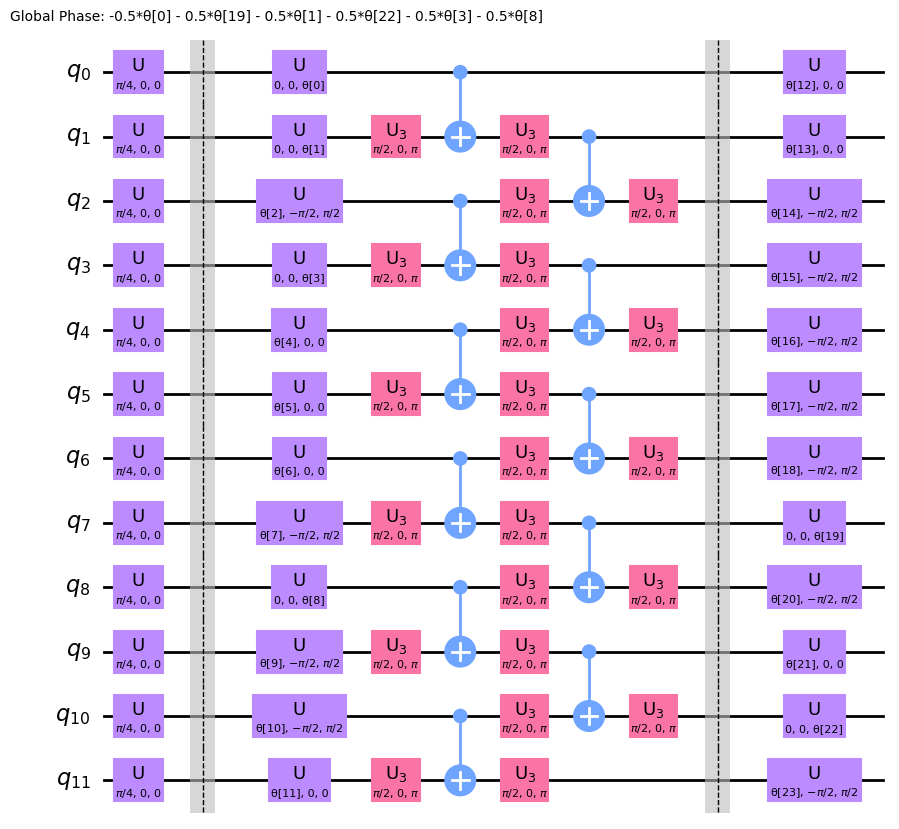

In [4]:
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, PauliTwoDesign, ExcitationPreserving

ansatz = PauliTwoDesign(H2_op.num_qubits, reps=1, seed=5, insert_barriers=True)
ansatz = ansatz.decompose(reps=2)
 
print(ansatz.count_ops())
print(ansatz.depth())
ansatz.decompose(reps=2).draw('mpl')

Visualize the subcircuits:

In [5]:
circuit = ansatz.decompose(reps=3)

# See how many parameters are in our ansatz
num_params = circuit.num_parameters
print(f'Num parameters: {num_params}')

# List out the observables
observables_paulis = H2_op.paulis
observables = [str(i) for i in observables_paulis]
print(f'Observables: {observables}')

Num parameters: 24
Observables: ['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIZI', 'IIIIIIIIIIZZ', 'IIIIIIIIIXIX', 'IIIIIIIIIXZX', 'IIIIIIIIIYIY', 'IIIIIIIIIYZY', 'IIIIIIIIIZII', 'IIIIIIIIIZIZ', 'IIIIIIIIIZZI', 'IIIIIIIIXIXI', 'IIIIIIIIXXXX', 'IIIIIIIIXXYY', 'IIIIIIIIXYYX', 'IIIIIIIIXZXI', 'IIIIIIIIXZXZ', 'IIIIIIIIYIYI', 'IIIIIIIIYXXY', 'IIIIIIIIYYXX', 'IIIIIIIIYYYY', 'IIIIIIIIYZYI', 'IIIIIIIIYZYZ', 'IIIIIIIIZIII', 'IIIIIIIIZIIZ', 'IIIIIIIIZIZI', 'IIIIIIIIZXZX', 'IIIIIIIIZYZY', 'IIIIIIIIZZII', 'IIIIIIIXIXII', 'IIIIIIIXIZZX', 'IIIIIIIXXIXX', 'IIIIIIIXXIYY', 'IIIIIIIXXXXI', 'IIIIIIIXXYYI', 'IIIIIIIXYIYX', 'IIIIIIIXYYXI', 'IIIIIIIXZIZX', 'IIIIIIIXZXII', 'IIIIIIIXZXIZ', 'IIIIIIIXZXZI', 'IIIIIIIXZZIX', 'IIIIIIIXZZZX', 'IIIIIIIYIYII', 'IIIIIIIYIZZY', 'IIIIIIIYXIXY', 'IIIIIIIYXXYI', 'IIIIIIIYYIXX', 'IIIIIIIYYIYY', 'IIIIIIIYYXXI', 'IIIIIIIYYYYI', 'IIIIIIIYZIZY', 'IIIIIIIYZYII', 'IIIIIIIYZYIZ', 'IIIIIIIYZYZI', 'IIIIIIIYZZIY', 'IIIIIIIYZZZY', 'IIIIIIIZIIII', 'IIIIIIIZIIIZ', 'IIIIIIIZIIZI', 'IIIIII

In [6]:
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import cut_wires_and_gates_to_subcircuits

subcircuits, subobservables = cut_wires_and_gates_to_subcircuits(
    circuit=circuit,
    observables=observables,
    method='automatic',
    max_subcircuit_width=H2_op.num_qubits/2,
    max_cuts=4,
    num_subcircuits=[2],
    model='gurobi'
)

Restricted license - for non-production use only - expires 2024-10-28
Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 271 rows, 141 columns and 834 nonzeros
Model fingerprint: 0x207720df
Variable types: 0 continuous, 141 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 57 rows and 47 columns
Presolve time: 0.00s
Presolved: 214 rows, 94 columns, 617 nonzeros
Variable types: 0 continuous, 94 integer (81 binary)
Found heuristic solution: objective 4.0000000
Found heuristic solution: objective 3.0000000

Root relaxation: objective 5.454545e-01, 99 iterations, 0.00

/home/vhazoglou/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


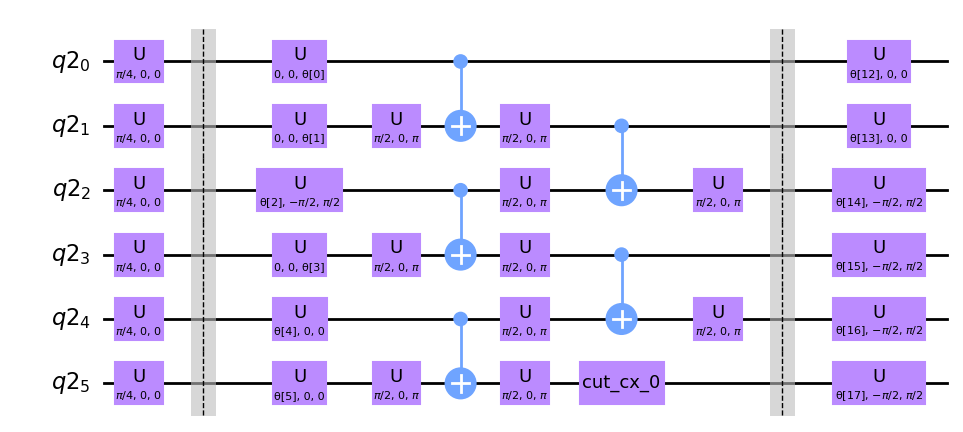

In [7]:
subcircuits[0].draw('mpl')

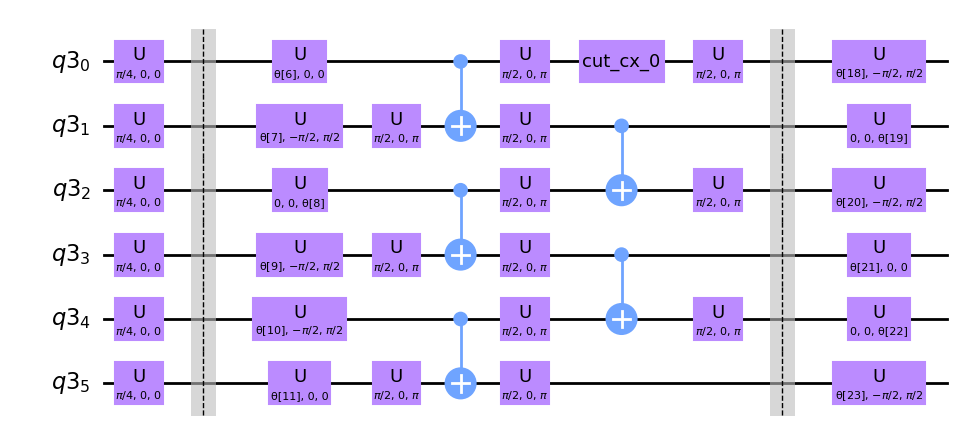

In [8]:
subcircuits[1].draw('mpl')

### 3. Get Energies for Cut Problem and Compare with Original (PauliTwoDesign)

In [9]:
# Create a callback function that will be used to get VQE data during the run 
def callback(eval_count, parameters, mean, std):
    print(f"Round num: {eval_count}, energy: {mean}, parameters: {parameters}")

In [10]:
# Use the modified CutVQE to cut and run VQE for our problem
estimator = Estimator()
optimizer = COBYLA(maxiter=80)
vqe = CutVQE(estimator, circuit, optimizer, observables=observables, shots=2**12, max_subcircuit_width=H2_op.num_qubits/2, max_cuts=9, num_subcircuits=[2], model='gurobi', num_samples=1500, callback=callback)
result = vqe.compute_minimum_eigenvalue(H2_op)
print(result)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 271 rows, 141 columns and 834 nonzeros
Model fingerprint: 0xa608bab0
Variable types: 0 continuous, 141 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 57 rows and 47 columns
Presolve time: 0.00s
Presolved: 214 rows, 94 columns, 617 nonzeros
Variable types: 0 continuous, 94 integer (81 binary)
Found heuristic solution: objective 4.0000000

Root relaxation: objective 5.454545e-01, 99 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl | 

Round num: 20, energy: 7.123686683526029, parameters: [-3.56352298  3.19492141 -0.71570168  0.25717134  0.81220418 -5.39888671
  6.94034014 -1.96028619  0.44133898  3.74368193  4.26310418  0.18692299
 -4.03132361 -4.22948919  3.00913173 -4.83054564 -2.27458552 -1.50207358
  4.07626884 -5.81795073 -4.61912612  2.73860441 -0.34552387 -0.89919274]
Round num: 21, energy: 6.639312185479215, parameters: [-3.56352298  3.19492141 -0.71570168  0.25717134  0.81220418 -5.39888671
  6.94034014 -1.96028619  0.44133898  3.74368193  4.26310418  0.18692299
 -4.03132361 -4.22948919  3.00913173 -4.83054564 -2.27458552 -1.50207358
  3.07626884 -4.81795073 -4.61912612  2.73860441 -0.34552387 -0.89919274]
Round num: 22, energy: 7.140126961066037, parameters: [-3.56352298  3.19492141 -0.71570168  0.25717134  0.81220418 -5.39888671
  6.94034014 -1.96028619  0.44133898  3.74368193  4.26310418  0.18692299
 -4.03132361 -4.22948919  3.00913173 -4.83054564 -2.27458552 -1.50207358
  3.07626884 -4.81795073 -3.61912

Round num: 44, energy: 3.2583837927061756, parameters: [-3.92138393  3.38683623 -0.07239186  1.00642028  1.36197322 -7.61205825
  7.66895341 -1.31789012  0.13213538  3.96008005  3.52214192  0.04530084
 -3.82729184 -4.51913019  3.66118157 -4.86519503 -2.06608685 -0.32546155
  2.63621722 -4.6239328  -5.27471678  2.23842676 -0.3709736   0.95918978]
Round num: 45, energy: 2.6698362063652863, parameters: [-3.88632922  3.35742998 -0.01883346  1.06162583  1.17304201 -7.26691035
  7.54702247 -1.35772806  0.11791057  3.78006622  3.61286494  0.07261827
 -3.74970941 -4.40341206  3.30894466 -4.69434606 -1.30622638 -0.61305685
  2.20995286 -4.64247442 -5.21206428  2.28622698 -0.36854146  0.86919183]
Round num: 46, energy: 2.3082967365810636, parameters: [-3.92278959  3.38801539 -0.0745395   1.0042066   1.36954917 -7.62589834
  7.67384272 -1.31629265  0.13270578  3.96729843  3.51850401  0.04420544
 -3.83040281 -4.52377037  3.32584078 -4.52258076 -0.98810179 -1.14765453
  2.97738714 -4.6231893  -5.27

Round num: 66, energy: 0.16581705257839544, parameters: [-3.79521666e+00  3.17490053e+00 -8.77911874e-01  1.46312593e+00
  2.55654109e+00 -7.26734581e+00  7.88875107e+00 -9.93512955e-01
  6.65210664e-03  5.19347302e+00  3.48255027e+00 -2.96336034e-03
 -4.01378999e+00 -4.03319496e+00  3.53411500e+00 -3.85184103e+00
  3.76777762e-01 -4.54365505e-01  3.01130148e+00 -3.81400838e+00
 -5.04580310e+00  2.89226664e+00 -9.47638023e-01 -1.98004197e-01]
Round num: 67, energy: 0.18585901796719, parameters: [-3.77486896  3.17787447 -0.87720996  1.46400729  2.43302987 -7.24318013
  7.85015699 -1.01200187 -0.17299518  4.91436178  3.35257602  0.39397326
 -3.73686442 -4.95151308  3.60850386 -3.8150893   0.26121956 -0.47287542
  2.99228225 -3.84757032 -5.01746409  2.87148997 -0.90458964 -0.15191108]
Round num: 68, energy: 0.45339912518998104, parameters: [-3.78723397  3.16434092 -0.85985868  1.48170391  2.51618604 -7.15479105
  7.85478203 -1.00347831 -0.16813905  4.98155094  3.78018351 -0.55646882
 -3.7

In [11]:
# Do the same thing to compare againt not cutting at all
estimator = Estimator()
optimizer = COBYLA(maxiter=80)
no_cut_vqe = VQE(ansatz=circuit, optimizer=optimizer, estimator=estimator, callback=callback)
no_cut_result = no_cut_vqe.compute_minimum_eigenvalue(H2_op)
print(no_cut_result)

Round num: 1, energy: 11.555152455412241, parameters: [4.014170103654898, -3.7432850936177915, -1.7357797292981312, -2.646515282125884, 6.138360046632515, 2.122614358646164, 1.6023153231110152, 1.9623563236763708, -1.3806543868035543, 1.7132242734104661, -4.027725233419897, -1.5981715684352942, -1.0320865700138748, 1.480442021020103, -1.5883767502029968, 0.4099071338011404, -4.499234949468319, -0.7471587301438056, 0.0468988589551822, 1.3827801392485313, 2.3164136279341854, 3.5215942379225567, 0.9516040475661569, 4.319061286487278]
Round num: 2, energy: 11.067644312861363, parameters: [5.014170103654898, -3.7432850936177915, -1.7357797292981312, -2.646515282125884, 6.138360046632515, 2.122614358646164, 1.6023153231110152, 1.9623563236763708, -1.3806543868035543, 1.7132242734104661, -4.027725233419897, -1.5981715684352942, -1.0320865700138748, 1.480442021020103, -1.5883767502029968, 0.4099071338011404, -4.499234949468319, -0.7471587301438056, 0.0468988589551822, 1.3827801392485313, 2.316

Round num: 18, energy: 8.721832780558787, parameters: [5.014170103654898, -3.7432850936177915, -0.7357797292981312, -2.646515282125884, 7.138360046632515, 3.122614358646164, 1.6023153231110152, 1.9623563236763708, -0.38065438680355435, 2.713224273410466, -4.027725233419897, -1.5981715684352942, -0.03208657001387483, 1.480442021020103, -0.5883767502029968, 0.4099071338011404, -3.4992349494683186, -0.7471587301438056, 0.0468988589551822, 1.3827801392485313, 2.3164136279341854, 3.5215942379225567, 0.9516040475661569, 4.319061286487278]
Round num: 19, energy: 9.087061396972944, parameters: [5.014170103654898, -3.7432850936177915, -0.7357797292981312, -2.646515282125884, 7.138360046632515, 3.122614358646164, 1.6023153231110152, 1.9623563236763708, -0.38065438680355435, 2.713224273410466, -4.027725233419897, -1.5981715684352942, -0.03208657001387483, 1.480442021020103, -0.5883767502029968, 0.4099071338011404, -3.4992349494683186, 0.2528412698561944, 0.0468988589551822, 1.3827801392485313, 2.

Round num: 35, energy: 3.8619678469800847, parameters: [4.811179845119802, -3.3912391592200386, -0.38370853063769983, -2.59709115110779, 7.904211722058919, 3.7727359553154667, 1.9357982535861602, 2.410356752917755, -0.3420957474401988, 3.348562485258894, -4.630597357318372, -1.8405039455230743, 0.23620540225211323, 0.9065203162464952, -0.17563559996072925, -0.3612449174903743, -3.3267071100956427, -1.1803214482368178, 1.3290479884498507, 2.44488380647798, 2.1354299859132246, 2.7762008360594144, 0.9268608039123964, 6.982588843058835]
Round num: 36, energy: 3.807447858263543, parameters: [4.811179845119802, -3.3912391592200386, -0.38370853063770005, -2.59709115110779, 7.904211722058919, 3.7727359553154667, 1.9357982535861602, 2.410356752917755, 0.15698597121909147, 3.3182732445934544, -4.630597357318372, -1.8405039455230743, 0.23620540225211323, 0.9065203162464952, -0.17563559996072925, -0.3612449174903743, -3.3267071100956427, -1.1803214482368178, 1.3290479884498507, 2.44488380647798, 2

Round num: 53, energy: 0.2638019946713065, parameters: [5.582636367212484, -3.5143908387041516, 0.4671463509678199, -2.981666006908975, 9.053608369738528, 4.859300478841916, 1.6462135312399513, 1.814262305621061, 0.2333782958270409, 3.2532198961981966, -6.513185274641199, -0.8449957763072686, 0.2457927481557187, 0.632465119656344, -0.3714925252526868, -0.2720990128860355, -3.2006569609436926, -0.6465535494002089, 1.289165600350528, 2.9358296843811527, 1.5209478142612665, 3.183774946463834, 0.6319086070503057, 6.6500606570665814]
Round num: 54, energy: 0.08003288730341351, parameters: [6.35610370494617, -3.469716230838285, 0.4846973954909377, -2.986263421505904, 9.099353163779622, 4.793121941053313, 1.7269225860522688, 1.8727171848967705, 0.246454030899658, 3.085144169990161, -6.328173020400158, -0.630080203500625, 0.20204186519565398, 0.6818494714097159, -0.4086951871664208, -0.09937342059188534, -3.104551743025828, -0.4431253875659004, 1.262728220119355, 2.9293193858657394, 1.50322717

Round num: 71, energy: -0.3929974783980339, parameters: [6.3143730901798385, -3.5276863816450965, 0.23285735128050622, -2.7282590797739203, 8.495751229093106, 5.799069455488371, 1.7715221646226214, 1.9022349854154337, 0.255028774120398, 2.995039931135034, -6.3494701122446005, -0.5047261910814302, 0.7908675469766404, 0.7014364686583838, -0.6445388254306454, -0.2547485218344142, -3.022412590757839, -0.1588295368697944, 0.7822843702011018, 2.9283211212378633, 1.3463082985410486, 3.3735581649474553, 0.5524105182280035, 6.071739639649223]
Round num: 72, energy: -0.18585529319499974, parameters: [6.34448982505346, -3.51627424484329, 0.26574808641314734, -2.744650957402955, 8.578114096676153, 5.881854695804833, 1.770537979691761, 1.872071531666348, 0.26988379091140086, 3.0201501708372556, -6.447685905811831, -0.4565417927356748, 0.8162822268367373, 0.6215081865829231, -0.5890056250110334, -0.28966011184584056, -2.933889024317205, -0.10300373757149159, 0.5287527421902696, 2.9298462790138355, 2

In [12]:
print("CutVQE result:", result.optimal_value)
print("VQE result:", no_cut_result.optimal_value)

CutVQE result: -0.13148720555004093
VQE result: -0.39559798841140936


### 2. Create Ansatz and Cut (EfficientSU2)

OrderedDict([('r', 24), ('u3', 24), ('cx', 12), ('barrier', 2)])
16


/home/vhazoglou/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


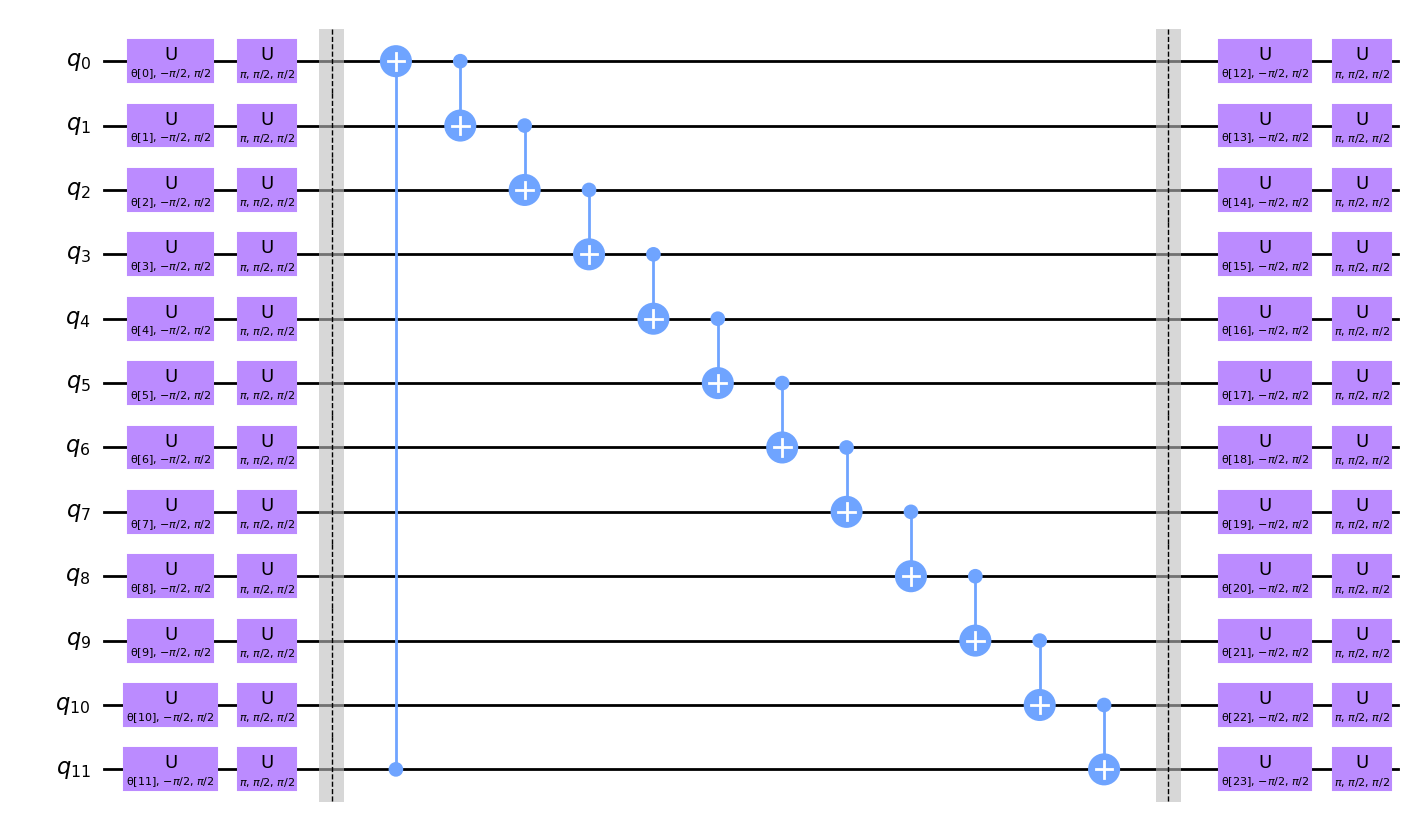

In [13]:
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, PauliTwoDesign, ExcitationPreserving

ansatz = EfficientSU2(H2_op.num_qubits, su2_gates=['rx', 'y'], entanglement='circular', reps=1, insert_barriers=True)

ansatz = ansatz.decompose(reps=2)
 
print(ansatz.count_ops())
print(ansatz.depth())
ansatz.decompose(reps=2).draw('mpl')

In [14]:
circuit = ansatz.decompose(reps=3)

# See how many parameters are in our ansatz
num_params = circuit.num_parameters

# List out the observables
observables_paulis = H2_op.paulis
observables = [str(i) for i in observables_paulis]

from circuit_knitting.cutting.gate_and_wire_cutting.frontend import cut_wires_and_gates_to_subcircuits

subcircuits, subobservables = cut_wires_and_gates_to_subcircuits(
    circuit=circuit,
    observables=observables,
    method='automatic',
    max_subcircuit_width=H2_op.num_qubits/2,
    max_cuts=4,
    num_subcircuits=[2],
    model='gurobi'
)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297 rows, 151 columns and 926 nonzeros
Model fingerprint: 0xda58d23a
Variable types: 0 continuous, 151 integer (120 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 61 rows and 48 columns
Presolve time: 0.00s
Presolved: 236 rows, 103 columns, 679 nonzeros
Variable types: 0 continuous, 103 integer (89 binary)
Found heuristic solution: objective 4.0000000

Root relaxation: objective 1.090909e+00, 95 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl 

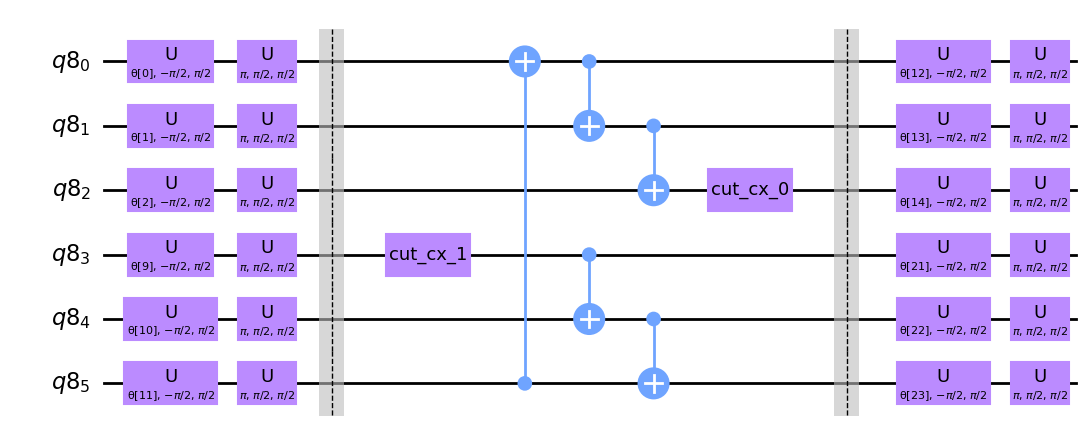

In [15]:
subcircuits[0].draw('mpl')

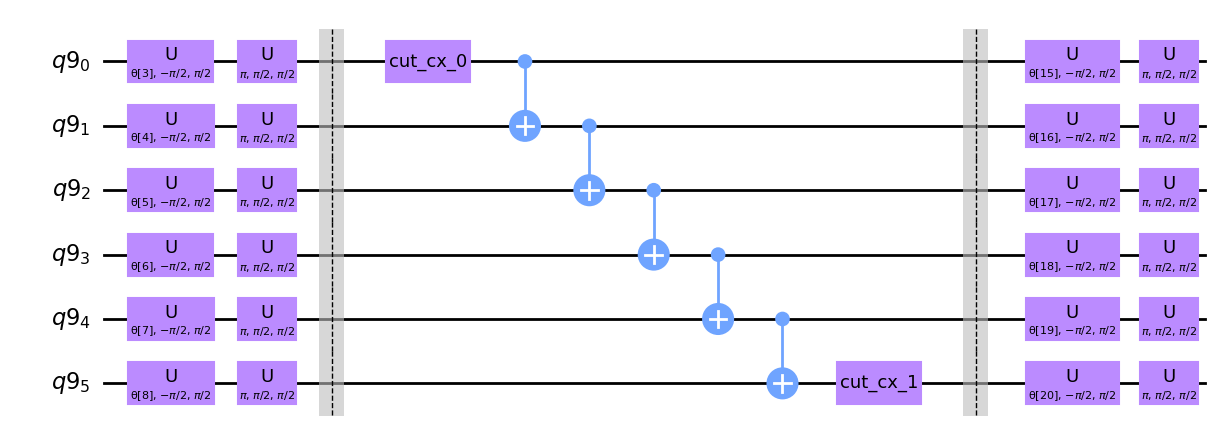

In [16]:
subcircuits[1].draw('mpl')

### 3. Get Energies for Cut Problem and Compare with Original (EfficientSU2)

In [17]:
# Use the modified CutVQE to cut and run VQE for our problem
estimator = Estimator()
optimizer = COBYLA(maxiter=80)
vqe = CutVQE(estimator, circuit, optimizer, observables=observables, shots=2**12, max_subcircuit_width=H2_op.num_qubits/2, max_cuts=9, num_subcircuits=[2], model='gurobi', num_samples=1500, callback=callback)
result = vqe.compute_minimum_eigenvalue(H2_op)
print(result)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297 rows, 151 columns and 926 nonzeros
Model fingerprint: 0x0905d28a
Variable types: 0 continuous, 151 integer (120 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 61 rows and 48 columns
Presolve time: 0.00s
Presolved: 236 rows, 103 columns, 679 nonzeros
Variable types: 0 continuous, 103 integer (89 binary)
Found heuristic solution: objective 6.0000000
Found heuristic solution: objective 4.0000000

Root relaxation: objective 1.090909e+00, 95 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     

Round num: 20, energy: 5.743556424433817, parameters: [ 2.91884    -0.7574466  -2.22911395  5.97625965  1.07058735  6.35790369
 -0.10505123 -2.02863946 -3.78709549 -4.42404285 -1.54519116  3.8082479
  6.16162717 -4.52887748 -5.30892038  2.71467472 -1.99736636  2.60517525
  3.26224487 -1.7566207   2.46039884 -3.73768174  0.30382397  0.63051949]
Round num: 21, energy: 6.013583200969527, parameters: [ 2.91884    -0.7574466  -2.22911395  5.97625965  1.07058735  6.35790369
 -0.10505123 -2.02863946 -3.78709549 -4.42404285 -1.54519116  3.8082479
  6.16162717 -4.52887748 -5.30892038  2.71467472 -1.99736636  2.60517525
  2.26224487 -0.7566207   2.46039884 -3.73768174  0.30382397  0.63051949]
Round num: 22, energy: 5.810944289705623, parameters: [ 2.91884    -0.7574466  -2.22911395  5.97625965  1.07058735  6.35790369
 -0.10505123 -2.02863946 -3.78709549 -4.42404285 -1.54519116  3.8082479
  6.16162717 -4.52887748 -5.30892038  2.71467472 -1.99736636  2.60517525
  2.26224487 -1.7566207   3.46039884

Round num: 44, energy: 4.741003056179541, parameters: [ 3.26186847 -0.04044592 -3.36735334  6.07911978  1.0712008   6.52515304
 -0.28054638 -2.21181646 -3.75134086 -4.54171663 -1.54305966  4.09154937
  6.25422685 -4.53690249 -4.97583599  2.54314162 -1.96363195  2.59115364
  2.4175307  -1.72187854  2.5856018  -3.57989623  0.41115171  0.77050908]
Round num: 45, energy: 4.8941474771817335, parameters: [ 3.23824556 -0.04994391 -3.32873294  6.05358101  1.09659663  6.51861935
 -0.26787818 -2.20428353 -3.76004443 -4.53077893 -1.5431989   3.77464172
  6.25937906 -4.78563896 -5.35657751  2.54625709 -1.93784096  2.61557901
  2.41547658 -1.71605819  2.58551283 -3.58211365  0.41223043  0.76945418]
Round num: 46, energy: 4.8867186287639095, parameters: [ 3.22021827 -0.07106459 -3.36876213  6.1145112   1.01904979  6.52182408
 -0.28340135 -2.20975128 -3.74824876 -4.54537398 -1.54296951  3.81940702
  6.26236431 -4.4625843  -5.40621863  2.57421205 -1.489841    2.58352741
  2.38577314 -1.75873413  2.552

Round num: 67, energy: 4.753818997008739, parameters: [ 3.26285318 -0.05704161 -3.26480846  5.96522871  1.10835091  6.63957441
 -0.15021249 -2.20170852 -3.73971023 -4.53310241 -1.3157598   3.79558959
  6.12306077 -4.51033265 -5.37662845  2.52418374 -1.95193412  2.63200779
  2.44209861 -1.70822503  2.38720175 -3.55930124  0.5632941   0.78389208]
Round num: 68, energy: 4.839397593992404, parameters: [ 3.2276936  -0.0350024  -3.32157154  6.02145509  1.15820471  6.51070336
 -0.30329742 -2.22162739 -3.78957088 -4.5545602  -1.29164454  3.77432636
  6.23003173 -4.53780276 -5.35418217  2.53062475 -1.94488762  2.53167069
  2.4315286  -1.69961879  2.38714719 -3.5661262   0.55902644  0.78590131]
Round num: 69, energy: 4.821735541330514, parameters: [ 3.19136644 -0.04072428 -3.33970177  6.03675519  1.15375227  6.49761225
 -0.36797769 -2.24636239 -3.80491952 -4.60001383 -1.33947518  3.80419086
  6.19611127 -4.48954909 -5.40160996  2.53716404 -1.98612972  2.77425917
  2.42671176 -1.72282361  2.37439

In [18]:
# Do the same thing to compare againt not cutting at all
estimator = Estimator()
optimizer = COBYLA(maxiter=80)
no_cut_vqe = VQE(ansatz=circuit, optimizer=optimizer, estimator=estimator, callback=callback)
no_cut_result = no_cut_vqe.compute_minimum_eigenvalue(H2_op)
print(no_cut_result)

Round num: 1, energy: 7.473905818098198, parameters: [5.611477944112545, 1.2895947931350484, 3.260749036370381, 0.10249432524879332, 1.053875026336386, 3.507041350977129, 4.042297396925493, -4.851486742693635, 1.9784182346741055, 0.8947013698410018, -6.040148663975976, 4.046595871195752, 3.1017380610275733, -5.555668750240175, 1.2784455169885183, -1.5500189717890303, 3.320602290265324, -5.9128509703426815, 3.0373143301007257, -4.557053671886181, 2.1255734109666022, 5.126186060945935, 0.47385355573061894, -3.045568511401508]
Round num: 2, energy: 7.546306668953721, parameters: [6.611477944112545, 1.2895947931350484, 3.260749036370381, 0.10249432524879332, 1.053875026336386, 3.507041350977129, 4.042297396925493, -4.851486742693635, 1.9784182346741055, 0.8947013698410018, -6.040148663975976, 4.046595871195752, 3.1017380610275733, -5.555668750240175, 1.2784455169885183, -1.5500189717890303, 3.320602290265324, -5.9128509703426815, 3.0373143301007257, -4.557053671886181, 2.1255734109666022, 

Round num: 18, energy: 6.842330141726773, parameters: [5.611477944112545, 2.2895947931350484, 3.260749036370381, 1.1024943252487933, 2.053875026336386, 4.507041350977129, 4.042297396925493, -4.851486742693635, 1.9784182346741055, 0.8947013698410018, -6.040148663975976, 5.046595871195752, 3.1017380610275733, -4.555668750240175, 2.2784455169885183, -0.5500189717890303, 4.320602290265324, -5.9128509703426815, 3.0373143301007257, -4.557053671886181, 2.1255734109666022, 5.126186060945935, 0.47385355573061894, -3.045568511401508]
Round num: 19, energy: 6.966998715449127, parameters: [5.611477944112545, 2.2895947931350484, 3.260749036370381, 1.1024943252487933, 2.053875026336386, 4.507041350977129, 4.042297396925493, -4.851486742693635, 1.9784182346741055, 0.8947013698410018, -6.040148663975976, 5.046595871195752, 3.1017380610275733, -4.555668750240175, 2.2784455169885183, -0.5500189717890303, 4.320602290265324, -4.9128509703426815, 3.0373143301007257, -4.557053671886181, 2.1255734109666022, 

Round num: 36, energy: 5.966398620207666, parameters: [6.7889238673104915, 3.4155244620799055, 3.215823842727228, 0.6552605691239761, 2.275918124795392, 4.277793079837066, 3.2465731443042527, -4.890148757426202, 1.9053942072235663, 0.8843342869361432, -6.615972378368183, 5.415098859550691, 2.460343066791472, -4.15359950365959, 2.5438399926190205, -0.2554918663074033, 4.439958737541581, -6.574231135074723, 2.851258485936445, -4.597875590021247, 3.154921310377708, 6.460666054113442, 0.09217991834072822, -3.1180396746159023]
Round num: 37, energy: 6.083128188827815, parameters: [6.835825569975695, 3.5831291265771923, 3.208679756466324, 0.6339225438734654, 2.3746988163655054, 4.290061675877893, 3.1940571710875227, -4.891967665752062, 1.9019586901550338, 0.8838465530831363, -5.86347658124198, 5.432435595834596, 2.3669547804999866, -4.134683596011313, 2.5563258453274376, -0.24163542845599917, 4.445574027825793, -6.754965741547972, 3.6263020639593018, -4.599796114010673, 3.1563020231769396, 6

Round num: 52, energy: 5.287668094429016, parameters: [6.858489217669683, 3.7337457314159406, 3.204822995404863, 0.6562934081485251, 2.4463519600101016, 4.353439835898273, 3.59739347594045, -4.5411886285884435, 1.8495846835219278, 0.5176040846177586, -6.174126699400044, 5.955655052401067, 2.306752182742667, -3.8488100805878998, 2.736769191218501, -0.2293481528444386, 5.064214737034345, -6.834553645223959, 2.5709946917068427, -4.510712295547027, 3.5751239826444308, 5.526410886506868, 0.9008592827774307, -3.6326078956494046]
Round num: 53, energy: 4.241225327676983, parameters: [6.38609610595801, 3.4749974559097287, 3.203258900397777, 0.6113610546660349, 2.4462077654593712, 4.288702617731462, 2.777766488897069, -4.515879716456547, 1.8103128814497422, 0.5201607657624618, -6.18302660308648, 6.4346075477311135, 2.2979323554196482, -3.6355824171272917, 2.8675908505865384, -0.08437493325004441, 5.212137847131233, -6.895485399511637, 2.5281675510279475, -4.519745407122332, 3.5849564133492757, 

Round num: 70, energy: 3.8344420102544743, parameters: [5.979907288748589, 3.183244357790739, 2.9633756728194016, -0.08380096091197214, 3.0194089091425402, 3.7757653345062625, 2.3457913623285047, -5.936971671501712, 1.2337298753689239, 0.3665044904797598, -6.266427058192762, 6.305250571784866, 2.288218738160134, -2.9774210988837444, 3.4075498408167144, 0.5333213439376913, 4.6910232015398705, -7.008126810326324, 2.5813901283534255, -4.4996969162388005, 3.5806889919362725, 5.5587308205262325, 0.9733827466117998, -3.7064095635975587]
Round num: 71, energy: 2.627449675024978, parameters: [6.059021016930666, 3.2584389107399536, 3.038133869733002, 0.04765877776873684, 2.9574813267753965, 3.964532728863972, 2.38266275136631, -5.918926469885643, 1.2038563632764627, 0.41069420676343243, -6.238565746503983, 6.2473366452077785, 2.2730769645839746, -3.029568571921013, 3.2413413618030007, 0.09324132217933014, 5.52009945130841, -6.9744258306786335, 2.639976089212298, -4.006235315830084, 3.5817296814

In [19]:
print("CutVQE result:", result.optimal_value)
print("VQE result:", no_cut_result.optimal_value)

CutVQE result: 4.503890946219539
VQE result: 2.073698714018098


### 2. Create Ansatz and Cut (RealAmplitudes)

OrderedDict([('r', 24), ('cx', 11), ('barrier', 2)])
13


/home/vhazoglou/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


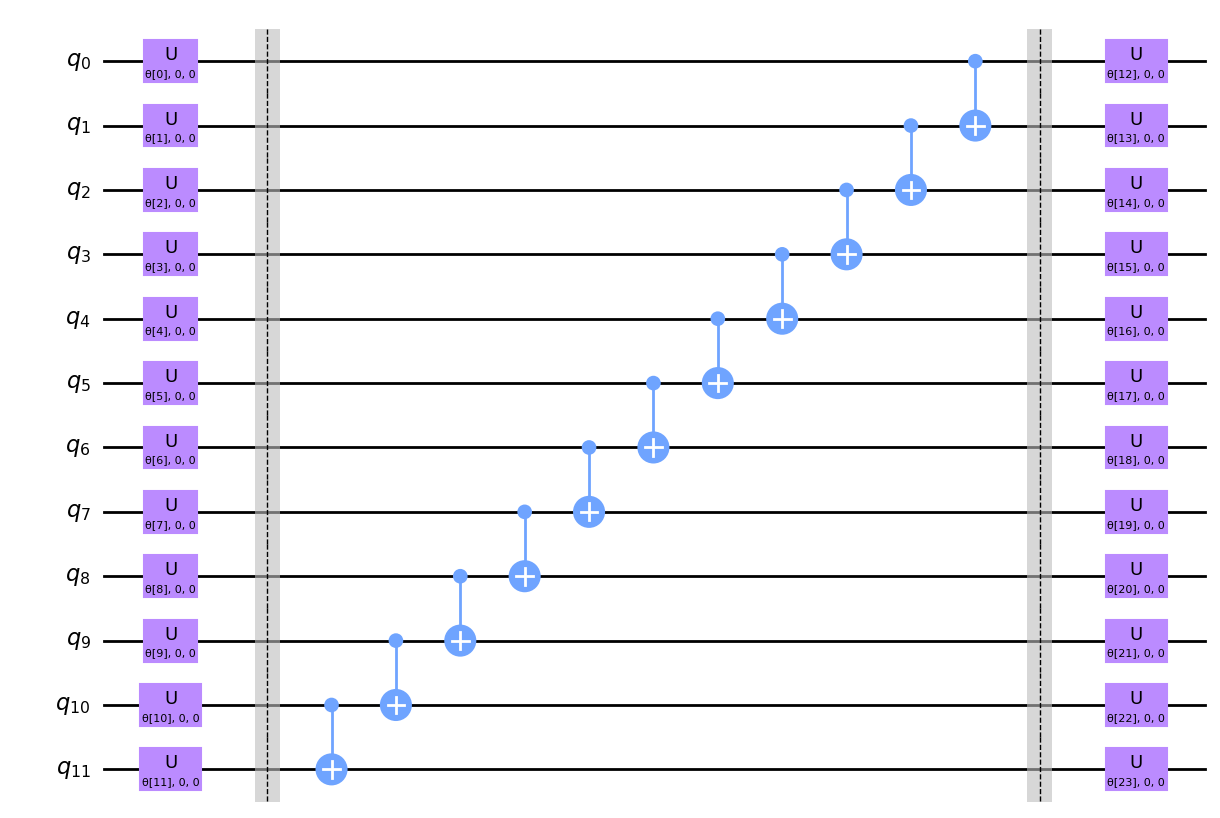

In [20]:
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, PauliTwoDesign, ExcitationPreserving

ansatz = RealAmplitudes(H2_op.num_qubits, reps=1, insert_barriers=True)
ansatz = ansatz.decompose(reps=2)
 
print(ansatz.count_ops())
print(ansatz.depth())
ansatz.decompose(reps=2).draw('mpl')

In [21]:
circuit = ansatz.decompose(reps=3)

# See how many parameters are in our ansatz
num_params = circuit.num_parameters

# List out the observables
observables_paulis = H2_op.paulis
observables = [str(i) for i in observables_paulis]

from circuit_knitting.cutting.gate_and_wire_cutting.frontend import cut_wires_and_gates_to_subcircuits

subcircuits, subobservables = cut_wires_and_gates_to_subcircuits(
    circuit=circuit,
    observables=observables,
    method='automatic',
    max_subcircuit_width=H2_op.num_qubits/2,
    max_cuts=4,
    num_subcircuits=[2],
    model='gurobi'
)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 271 rows, 141 columns and 834 nonzeros
Model fingerprint: 0x8fa34eb7
Variable types: 0 continuous, 141 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 69 rows and 52 columns
Presolve time: 0.01s
Presolved: 202 rows, 89 columns, 587 nonzeros
Variable types: 0 continuous, 89 integer (77 binary)
Found heuristic solution: objective 4.0000000
Found heuristic solution: objective 3.0000000
Found heuristic solution: objective 1.0000000

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread cou

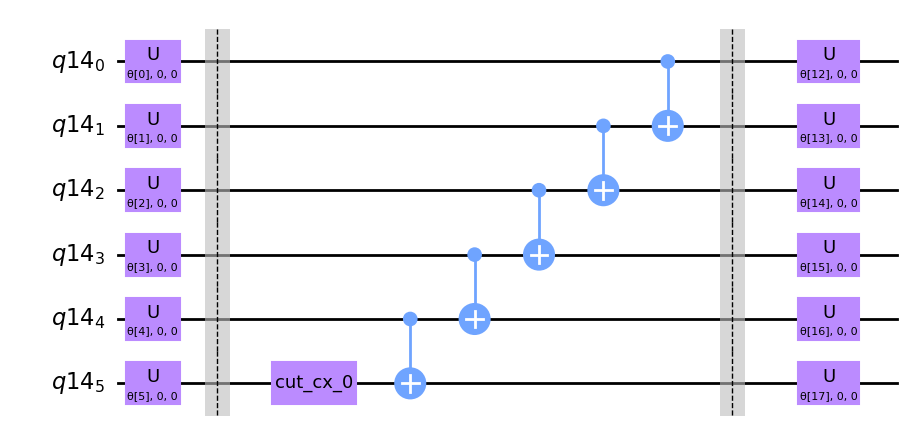

In [22]:
subcircuits[0].draw('mpl')

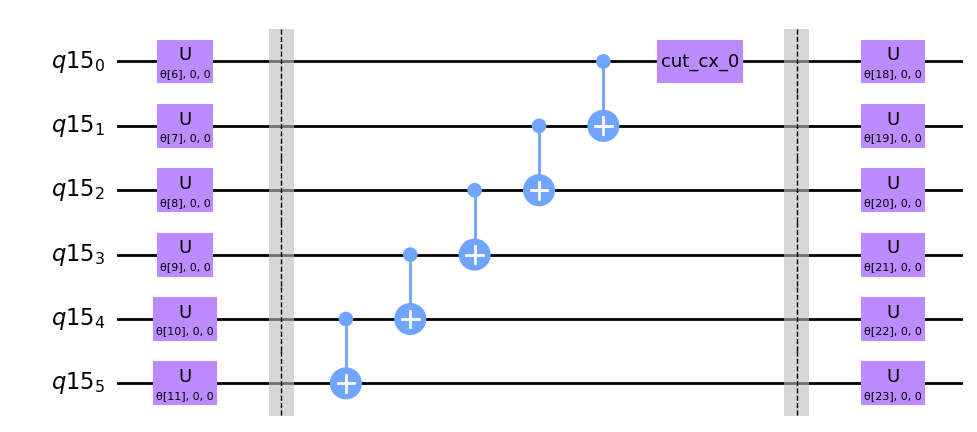

In [23]:
subcircuits[1].draw('mpl')

### 3. Get Energies for Cut Problem and Compare with Original (RealAmplitudes)

In [24]:
# Use the modified CutVQE to cut and run VQE for our problem
estimator = Estimator()
optimizer = COBYLA(maxiter=80)
vqe = CutVQE(estimator, circuit, optimizer, observables=observables, shots=2**12, max_subcircuit_width=H2_op.num_qubits/2, max_cuts=9, num_subcircuits=[2], model='gurobi', num_samples=1500, callback=callback)
result = vqe.compute_minimum_eigenvalue(H2_op)
print(result)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 271 rows, 141 columns and 834 nonzeros
Model fingerprint: 0x920c372c
Variable types: 0 continuous, 141 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 69 rows and 52 columns
Presolve time: 0.00s
Presolved: 202 rows, 89 columns, 587 nonzeros
Variable types: 0 continuous, 89 integer (77 binary)
Found heuristic solution: objective 4.0000000
Found heuristic solution: objective 3.0000000
Found heuristic solution: objective 1.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread cou

Round num: 22, energy: 3.1312481483038166, parameters: [-2.43668919 -0.22326405 -0.41751921  0.60836579  1.6686652   2.45412866
  3.56135458  2.81894726  6.51537938 -2.30934891  0.80380037 -3.89984878
  1.00639833  0.94530493  7.2050472  -6.0724641   3.86565759  5.02015551
  4.44233479  0.52078431  5.23280881 -2.82559757  3.68104258 -4.79792716]
Round num: 23, energy: 2.971529619447831, parameters: [-2.43668919 -0.22326405 -0.41751921  0.60836579  1.6686652   2.45412866
  3.56135458  2.81894726  6.51537938 -2.30934891  0.80380037 -3.89984878
  1.00639833  0.94530493  7.2050472  -6.0724641   3.86565759  5.02015551
  4.44233479  0.52078431  5.23280881 -1.82559757  3.68104258 -4.79792716]
Round num: 24, energy: 3.543520451545511, parameters: [-2.43668919 -0.22326405 -0.41751921  0.60836579  1.6686652   2.45412866
  3.56135458  2.81894726  6.51537938 -2.30934891  0.80380037 -3.89984878
  1.00639833  0.94530493  7.2050472  -6.0724641   3.86565759  5.02015551
  4.44233479  0.52078431  5.2328

Round num: 46, energy: 0.9901926869670762, parameters: [-2.65641212  0.10520564 -0.59270278  0.74673195 -0.22370631  3.38152288
  4.2015186   2.96337569  6.50142314 -2.06187137  0.2024425  -2.97738827
  0.67475873  1.07775158  7.77988362 -6.50016458  2.91369602  4.33551098
  3.95792476  0.47124044  5.42229303 -1.67439271  4.14030941 -5.10369105]
Round num: 47, energy: 0.21587350741690967, parameters: [-2.60139891  0.04018669 -0.56327456  0.70997445  0.08448775  3.38849631
  4.24408328  2.93177011  6.51047241 -2.12225777  0.28112449 -3.06158669
  0.72507891  1.05634928  7.74284245 -6.3578757   3.0791309   4.37727865
  3.99301602 -0.01339182  5.38813753 -1.70164816  3.23714967 -4.96860202]
Round num: 48, energy: 0.8167136843101765, parameters: [-2.62878268  0.07255099 -0.57792296  0.72827112 -0.06892112  3.38502516
  4.22289598  2.94750233  6.50596798 -2.0921994   0.24195918 -3.01967549
  0.70003118  1.06700264  7.76128033 -6.42870243  2.99678285  4.35648808
  3.97554875  0.65000517  5.4

Round num: 70, energy: 0.05495387704300278, parameters: [-2.60429203  0.09943171 -0.41424877 -0.23998497 -0.12215323  2.82955547
  4.699248    3.37903194  6.53959532 -2.21439976  0.26534192 -3.04696173
  0.9156344   1.06555468  7.98600587 -6.39623671  3.01105168  4.39343878
  3.98115755  0.48333663  5.42299565 -1.69026359  3.15451607 -5.11319348]
Round num: 71, energy: 0.21044587499720846, parameters: [-2.41117924  0.13044712 -0.43335007 -0.23096254 -0.3025733   2.805906
  4.69911031  3.4045584   6.53210068 -2.17383483  0.17844948 -3.05838015
  0.88620759  1.05573234  7.56287843 -6.46893653  3.21732101  4.36595822
  3.96668196  0.48566495  5.4549055  -1.68235947  3.06749003 -5.19205185]
Round num: 72, energy: 0.09255472119458716, parameters: [-2.66267254  0.09120911 -0.40949768 -0.24358679 -0.06730341  2.83385265
  4.72027802  3.37627162  6.53980094 -2.21906604  0.26702481 -3.04804115
  0.92219954  1.07077572  7.75084381 -6.39501155  2.97534539  4.40901367
  4.21580398  0.45737679  5.4

In [25]:
# Do the same thing to compare againt not cutting at all
estimator = Estimator()
optimizer = COBYLA(maxiter=80)
no_cut_vqe = VQE(ansatz=circuit, optimizer=optimizer, estimator=estimator, callback=callback)
no_cut_result = no_cut_vqe.compute_minimum_eigenvalue(H2_op)
print(no_cut_result)

Round num: 1, energy: 7.592866072710959, parameters: [5.694003317073127, 3.267446618557498, 3.7313683603422128, -1.192150958443431, -0.9370470472920509, -2.8543168577881106, -2.982705758865735, -4.290239113942443, 5.647191026480211, -3.9062756947369675, -1.396611028854772, -3.329257708385099, 3.115078976749574, 1.0762434067419235, -5.367878315700184, -2.6441553522689043, 1.3163813940899676, -5.76067381215576, -0.18742089389412175, -2.569311773846537, -3.6207757121760817, -6.176673271858868, 2.4543796451121302, 2.4598518327251195]
Round num: 2, energy: 7.591499828218346, parameters: [6.694003317073127, 3.267446618557498, 3.7313683603422128, -1.192150958443431, -0.9370470472920509, -2.8543168577881106, -2.982705758865735, -4.290239113942443, 5.647191026480211, -3.9062756947369675, -1.396611028854772, -3.329257708385099, 3.115078976749574, 1.0762434067419235, -5.367878315700184, -2.6441553522689043, 1.3163813940899676, -5.76067381215576, -0.18742089389412175, -2.569311773846537, -3.620775

Round num: 20, energy: 3.8820567307297367, parameters: [6.694003317073127, 4.267446618557498, 3.7313683603422128, -0.1921509584434311, -0.9370470472920509, -1.8543168577881106, -2.982705758865735, -4.290239113942443, 5.647191026480211, -3.9062756947369675, -0.39661102885477195, -2.329257708385099, 4.115078976749574, 2.0762434067419235, -5.367878315700184, -2.6441553522689043, 1.3163813940899676, -4.76067381215576, 0.8125791061058782, -2.569311773846537, -3.6207757121760817, -6.176673271858868, 2.4543796451121302, 2.4598518327251195]
Round num: 21, energy: 3.7195846681454054, parameters: [6.694003317073127, 4.267446618557498, 3.7313683603422128, -0.1921509584434311, -0.9370470472920509, -1.8543168577881106, -2.982705758865735, -4.290239113942443, 5.647191026480211, -3.9062756947369675, -0.39661102885477195, -2.329257708385099, 4.115078976749574, 2.0762434067419235, -5.367878315700184, -2.6441553522689043, 1.3163813940899676, -4.76067381215576, -0.18742089389412175, -1.569311773846537, -

Round num: 41, energy: 2.2949218975351275, parameters: [7.199021592477625, 4.241418547726347, 3.6884536960090575, -0.17189708781490834, -0.9181215999199644, -2.8609949360683187, -2.9282879868732397, -3.798276543330925, 5.689587320354349, -2.793069823455333, -0.2839703770230291, -2.2357245074387, 4.12785440397519, 2.0890882321472057, -5.848717161678604, -2.501180901896374, 1.2465375416413202, -4.74385531493615, -0.19189647361848441, -1.5618541221811995, -3.63565289249049, -6.178028256628898, 3.5053667619021613, 2.377344591184022]
Round num: 42, energy: 2.608666847549592, parameters: [7.207719938546888, 4.196305931502302, 3.6140727403475883, -0.13679248484054993, -0.885319459119598, -2.9053173383733957, -2.91725379117415, -3.7726143470824356, 5.637926925769991, -2.7626471876718917, -0.21620862529269952, -2.202427923387695, 4.1286547470730515, 2.1113512605034934, -5.497517896568109, -1.595544653205219, 1.183390990844198, -4.71470500197383, -0.19965367974394385, -1.5489283014512074, -3.661

Round num: 62, energy: 0.04370465666974614, parameters: [7.704378150340767, 3.9496559189065805, 3.2283503541744745, 0.2120758363717643, 0.5267269508934365, -2.8149915587126046, -3.0984339694890597, -3.533974571946659, 6.08429535578236, -3.1852304268509286, 0.5941103680851587, -1.9086688437469987, 4.261300624631533, 1.8671670415991426, -6.119011055440868, -3.195602874946485, -0.10231682367641634, -3.1725496007880643, 0.12500865598441618, -1.406199270512329, -2.8023600683126286, -6.757797468944092, 2.9283041862479378, 1.7145404458235785]
Round num: 63, energy: 0.07999620404334337, parameters: [7.70137387065309, 3.9652371472804164, 3.254040432778423, 0.19995122730010573, 0.5153975780984087, -2.7996832585031313, -3.1022450169852913, -3.5324930679405155, 6.102256541438585, -3.1955313288001848, 0.5711635589474279, -1.9197118952776089, 4.257432228597313, 1.7347700280139957, -6.27909984630418, -3.6083190819081823, -0.08116812335857436, -3.345904919728467, 0.1276878798978207, -1.410663657230958

In [26]:
print("CutVQE result:", result.optimal_value)
print("VQE result:", no_cut_result.optimal_value)

CutVQE result: -0.0840811293889305
VQE result: -0.024454899797547322


### 2. Create Ansatz and Cut (TwoLocal)

OrderedDict([('r', 24), ('cx', 22), ('u3', 22), ('u1', 11), ('barrier', 2)])
47


/home/vhazoglou/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


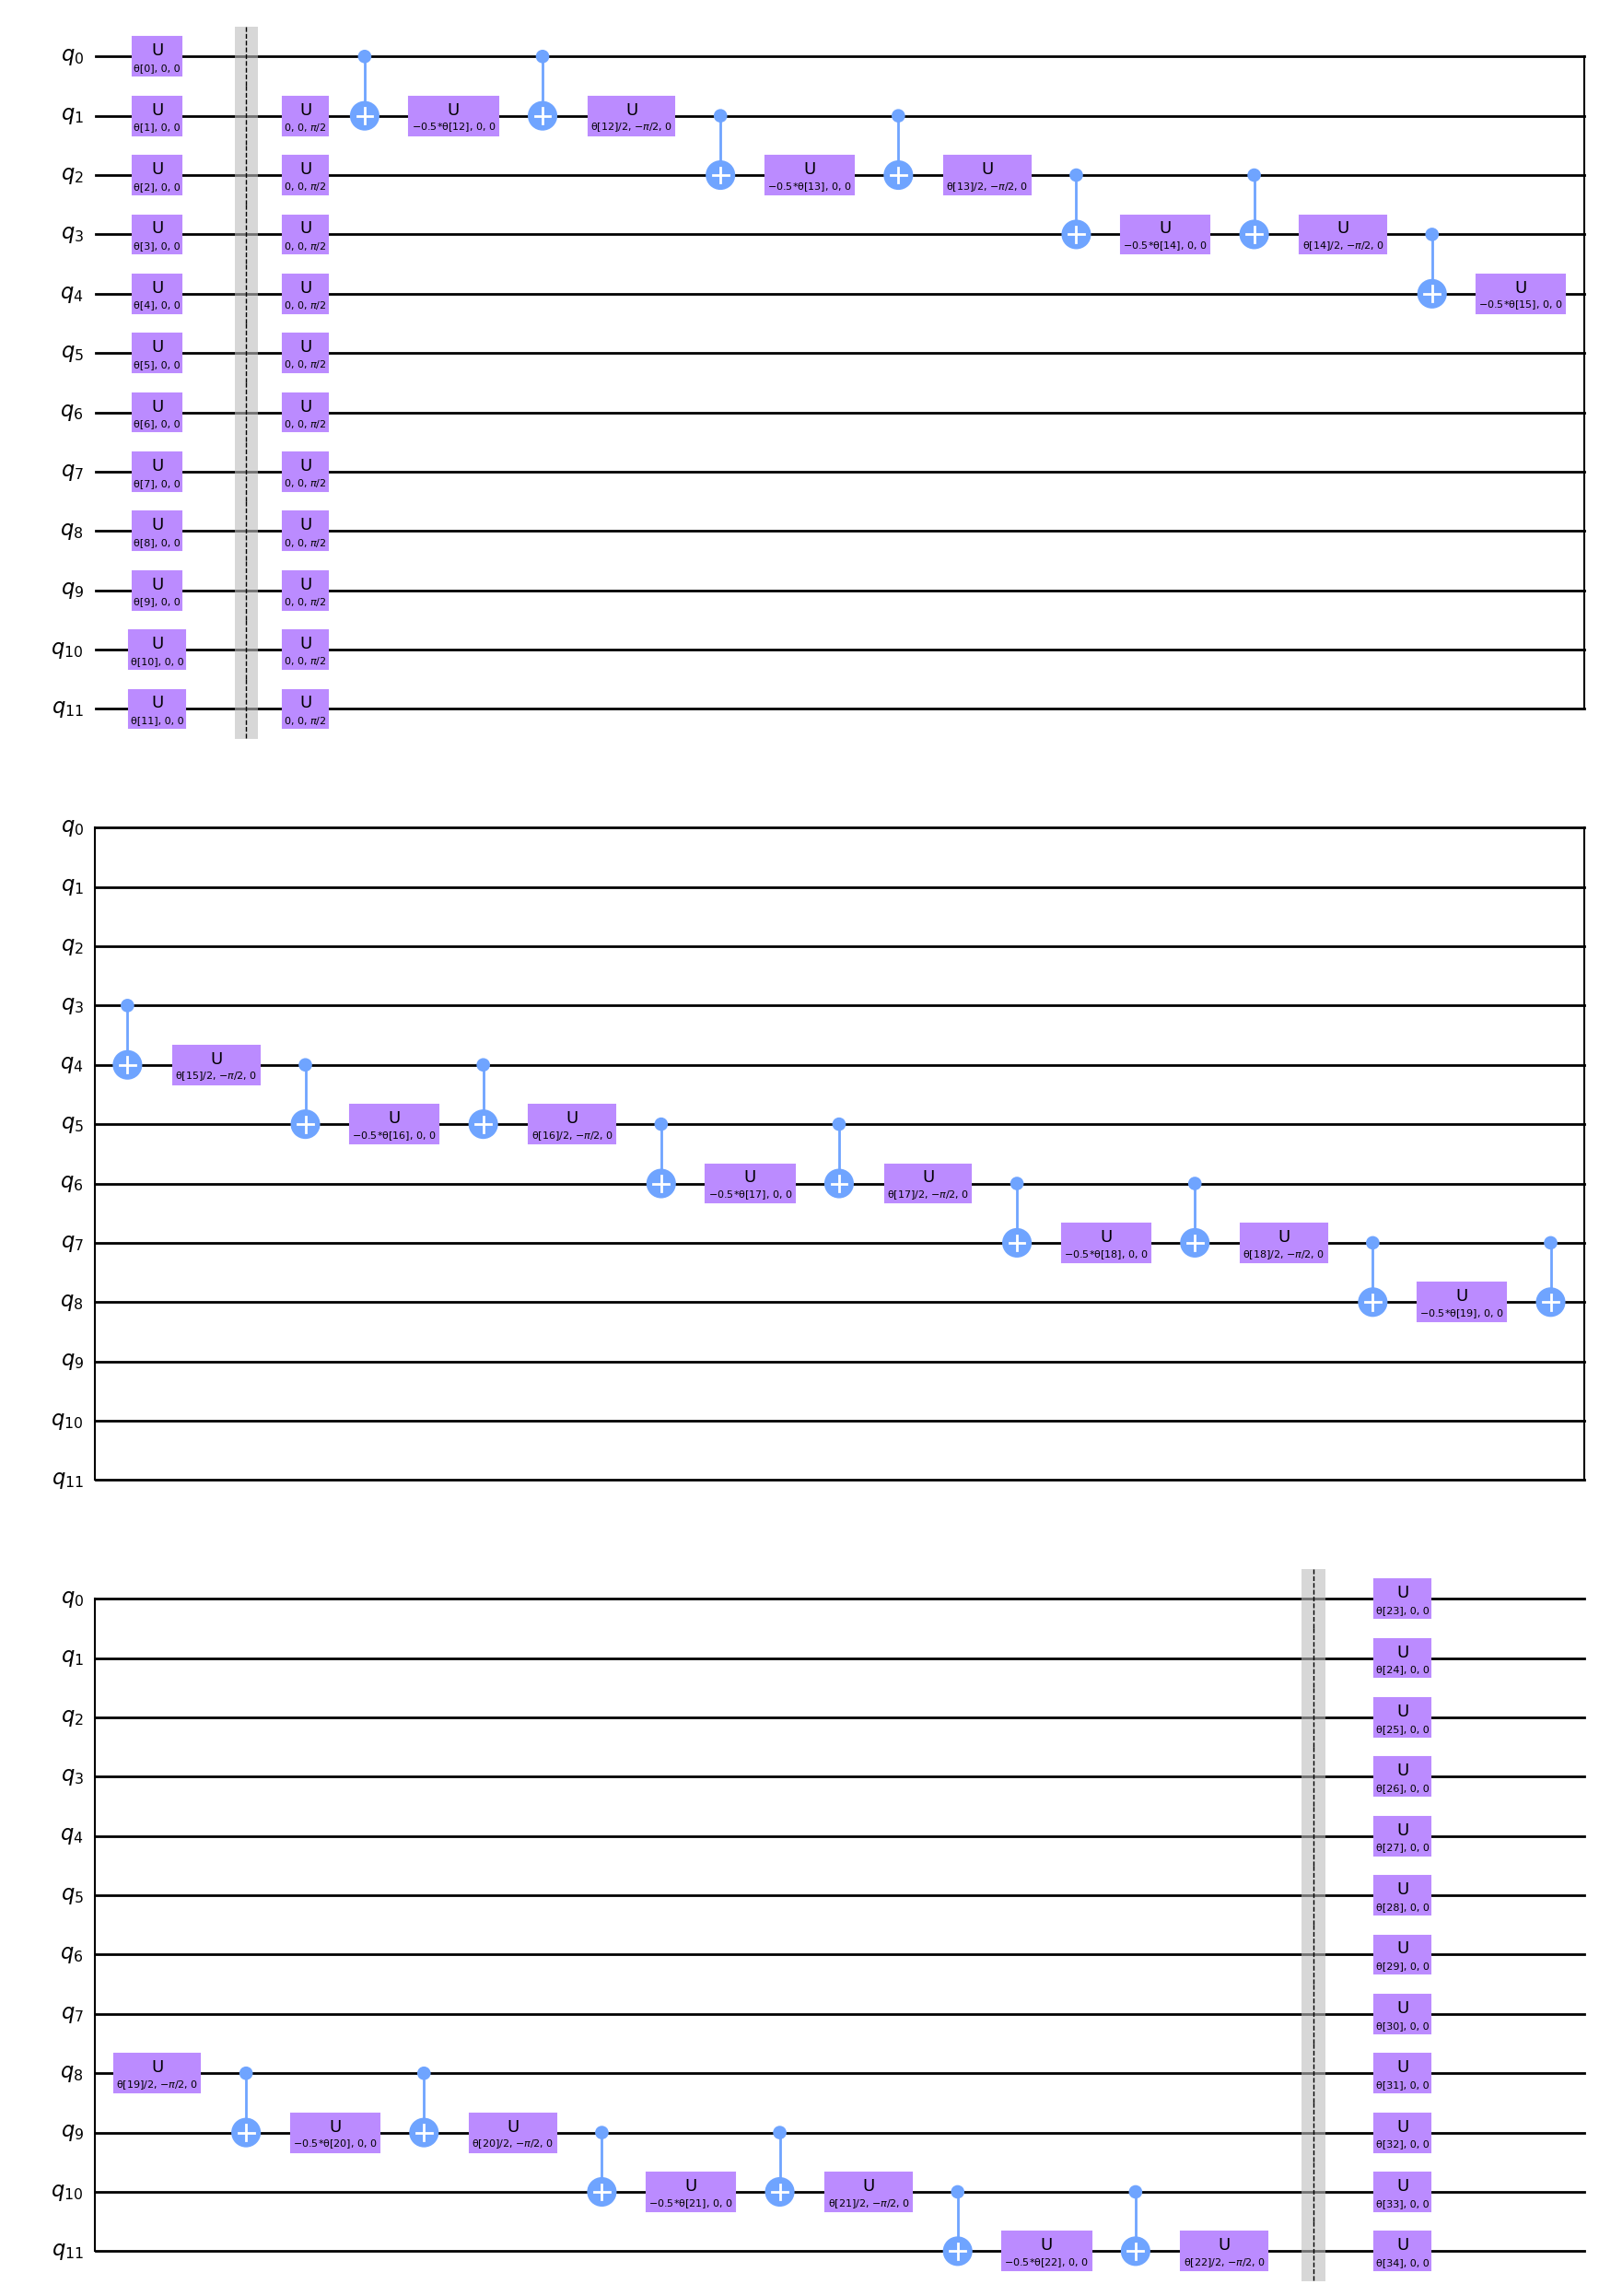

In [45]:
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, PauliTwoDesign, ExcitationPreserving

ansatz = TwoLocal(H2_op.num_qubits, 'ry', 'crx', 'linear', reps=1, insert_barriers=True)
ansatz = ansatz.decompose(reps=2)
 
print(ansatz.count_ops())
print(ansatz.depth())
ansatz.decompose(reps=2).draw('mpl')

In [46]:
circuit = ansatz.decompose(reps=3)

# See how many parameters are in our ansatz
num_params = circuit.num_parameters

# List out the observables
observables_paulis = H2_op.paulis
observables = [str(i) for i in observables_paulis]

from circuit_knitting.cutting.gate_and_wire_cutting.frontend import cut_wires_and_gates_to_subcircuits

subcircuits, subobservables = cut_wires_and_gates_to_subcircuits(
    circuit=circuit,
    observables=observables,
    method='automatic',
    max_subcircuit_width=H2_op.num_qubits/2,
    max_cuts=4,
    num_subcircuits=[2],
    model='gurobi'
)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 557 rows, 251 columns and 1846 nonzeros
Model fingerprint: 0xa84a4e9f
Variable types: 0 continuous, 251 integer (220 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 81 rows and 68 columns
Presolve time: 0.00s
Presolved: 476 rows, 183 columns, 1519 nonzeros
Variable types: 0 continuous, 183 integer (169 binary)
Found heuristic solution: objective 4.0000000
Found heuristic solution: objective 2.0000000

Root relaxation: infeasible, 175 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objectiv

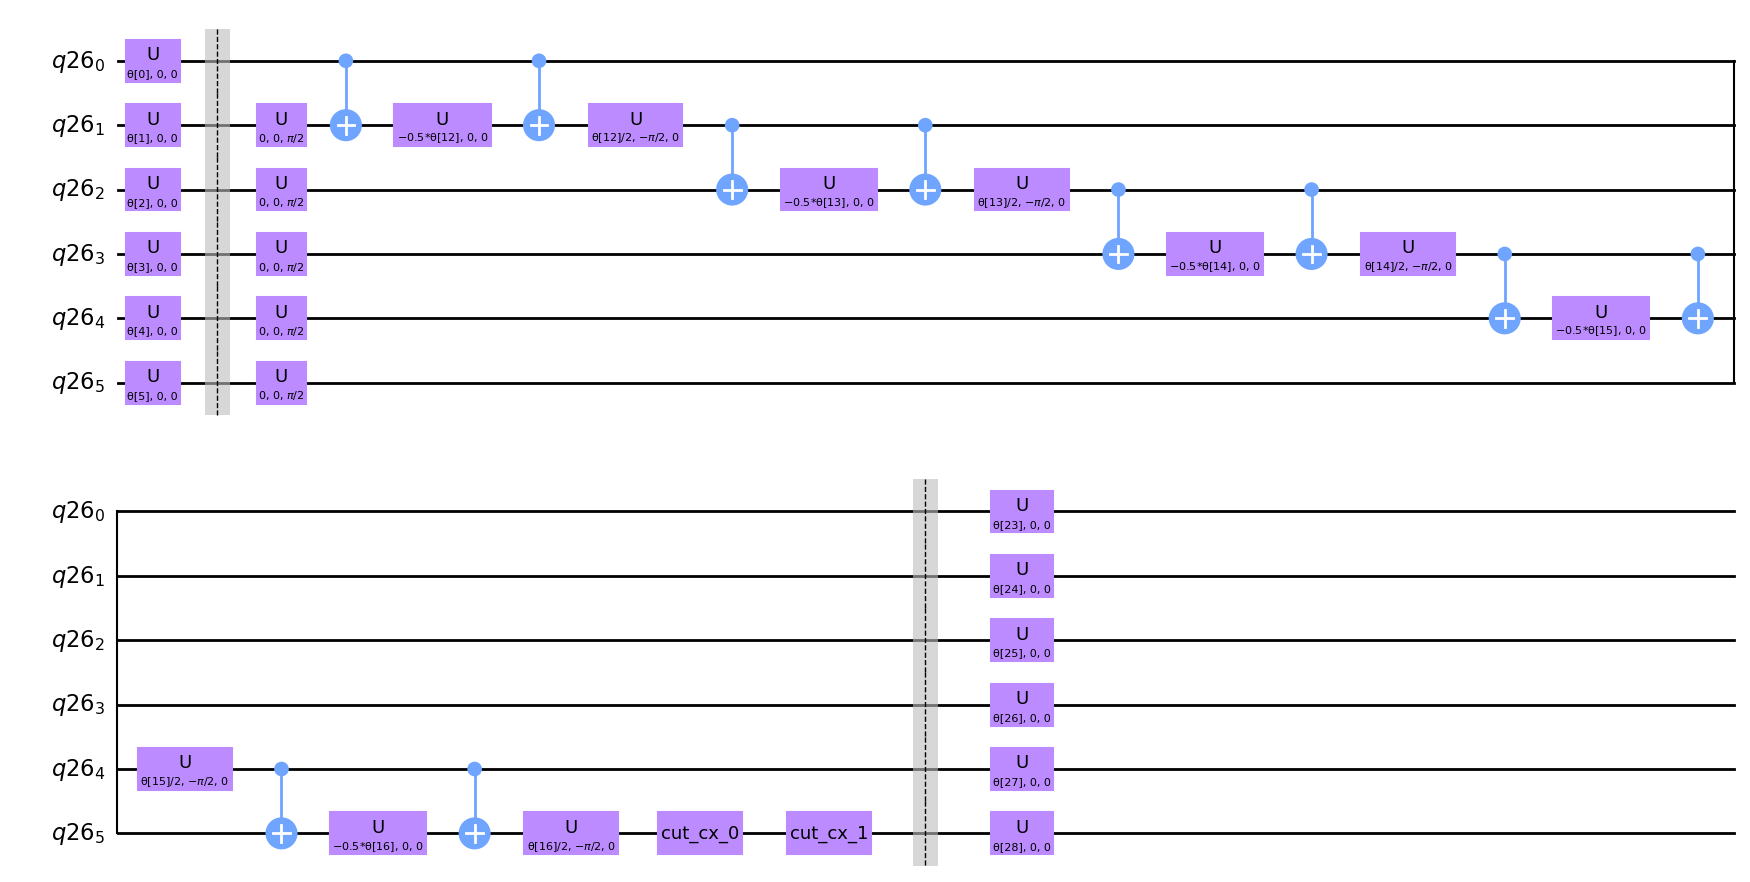

In [47]:
subcircuits[0].draw('mpl')

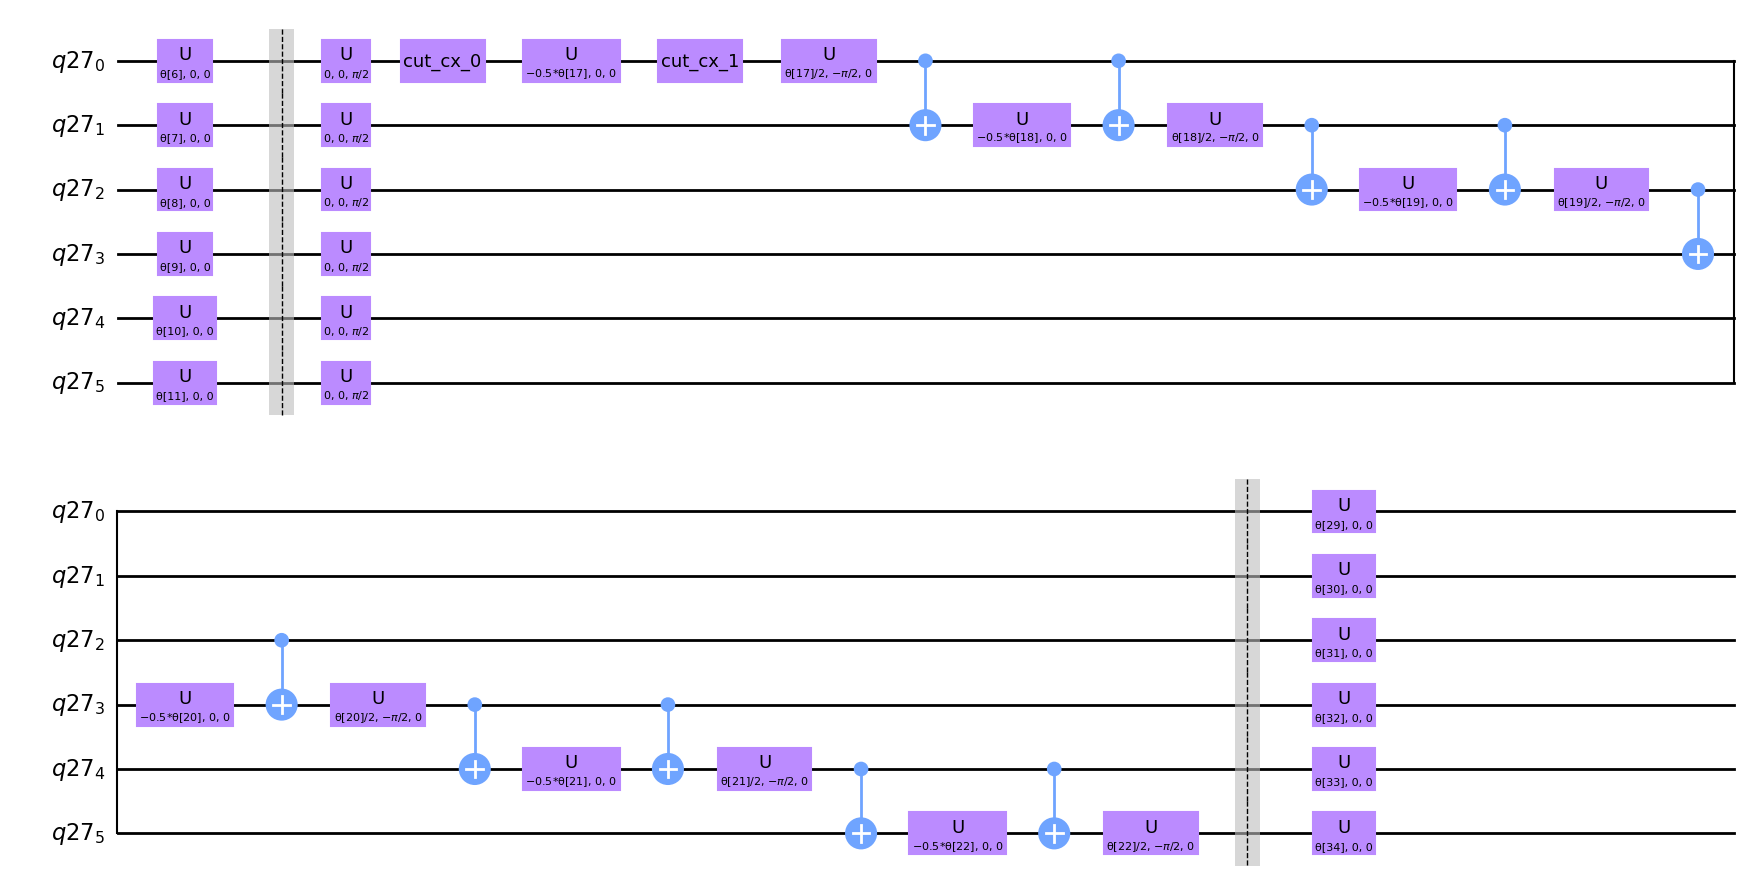

In [48]:
subcircuits[1].draw('mpl')

### 3. Get Energies for Cut Problem and Compare with Original (TwoLocal)

In [49]:
# Use the modified CutVQE to cut and run VQE for our problem
estimator = Estimator()
optimizer = COBYLA(maxiter=80)
vqe = CutVQE(estimator, circuit, optimizer, observables=observables, shots=2**12, max_subcircuit_width=H2_op.num_qubits/2, max_cuts=9, num_subcircuits=[2], model='gurobi', num_samples=1500, callback=callback)
result = vqe.compute_minimum_eigenvalue(H2_op)
print(result)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 557 rows, 251 columns and 1846 nonzeros
Model fingerprint: 0xfef7af05
Variable types: 0 continuous, 251 integer (220 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 81 rows and 68 columns
Presolve time: 0.00s
Presolved: 476 rows, 183 columns, 1519 nonzeros
Variable types: 0 continuous, 183 integer (169 binary)
Found heuristic solution: objective 8.0000000
Found heuristic solution: objective 2.0000000

Root relaxation: infeasible, 175 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objectiv

Round num: 15, energy: 2.2104852564884023, parameters: [-3.86251268 -1.43342883  2.6202154  -4.20576628 -0.36667289 -1.45890083
 -0.32715663  1.78458521  1.10799445 -5.10581824  4.54719478 -2.0950552
  2.40478873  4.83336713  4.39397367  5.40591373  1.29023449 -0.25524128
 -0.20316317  0.91558751 -4.8701945   1.30469659 -2.68430482 -1.10594021
 -1.85850154  3.17760691 -3.86823869 -0.9329206  -2.00947035 -3.80641399
  4.21056735  2.91975233  2.67944559 -1.03950861 -4.33145206]
Round num: 16, energy: 2.3869379947695943, parameters: [-3.86251268 -1.43342883  2.6202154  -4.20576628 -0.36667289 -1.45890083
 -0.32715663  1.78458521  1.10799445 -5.10581824  4.54719478 -2.0950552
  2.40478873  3.83336713  5.39397367  5.40591373  1.29023449 -0.25524128
 -0.20316317  0.91558751 -4.8701945   1.30469659 -2.68430482 -1.10594021
 -1.85850154  3.17760691 -3.86823869 -0.9329206  -2.00947035 -3.80641399
  4.21056735  2.91975233  2.67944559 -1.03950861 -4.33145206]
Round num: 17, energy: 2.8423584890605

Round num: 33, energy: 0.40135209202595246, parameters: [-3.86251268 -1.43342883  2.6202154  -4.20576628 -0.36667289 -1.45890083
 -0.32715663  1.78458521  1.10799445 -5.10581824  4.54719478 -2.0950552
  2.40478873  3.83336713  4.39397367  5.40591373  1.29023449  0.74475872
  0.79683683  1.91558751 -4.8701945   1.30469659 -1.68430482 -0.10594021
 -1.85850154  3.17760691 -3.86823869 -0.9329206  -1.00947035 -3.80641399
  5.21056735  3.91975233  2.67944559 -1.03950861 -4.33145206]
Round num: 34, energy: -0.05096481377284218, parameters: [-3.86251268 -1.43342883  2.6202154  -4.20576628 -0.36667289 -1.45890083
 -0.32715663  1.78458521  1.10799445 -5.10581824  4.54719478 -2.0950552
  2.40478873  3.83336713  4.39397367  5.40591373  1.29023449  0.74475872
  0.79683683  1.91558751 -4.8701945   1.30469659 -1.68430482 -0.10594021
 -1.85850154  3.17760691 -3.86823869 -0.9329206  -1.00947035 -3.80641399
  5.21056735  2.91975233  3.67944559 -1.03950861 -4.33145206]
Round num: 35, energy: 0.6238140684

Round num: 50, energy: -0.352355178410072, parameters: [-3.86251268 -1.43342883  2.6202154  -3.70848747 -0.41876694 -1.53297414
  0.08135675  1.62372298  0.94713222 -5.26668047  4.54719478 -1.68666874
  2.40478873  4.12184678  4.39397367  5.40591373  1.29023449  0.74475872
  0.79683683  1.91558751 -4.8701945   1.30469659 -1.68430482 -0.10594021
 -1.85850154  3.17760691 -3.86823869 -0.9329206  -1.00947035 -3.80641399
  5.21056735  2.91975233  3.67944559 -1.03950861 -4.33145206]
Round num: 51, energy: -0.20842707372253044, parameters: [-3.8637722  -1.43520254  2.61854048 -3.70609979 -0.41789444 -1.5271975
  0.08406884  1.62249414  0.94650024 -5.26596738  4.54449636 -2.26271326
  2.40358574  4.93900344  4.39215643  5.40033267  1.28639245  0.74496807
  0.79729118  1.91814258 -4.8702572   1.29340924 -1.67862472 -0.1033729
 -1.85917254  3.17538941 -3.86879768 -0.93576304 -1.00679843 -3.80774841
  5.21122608  2.9195481   3.68297952 -1.04508531 -4.33998708]
Round num: 52, energy: -0.1725076297

Round num: 67, energy: -0.06768423659894589, parameters: [-3.8859782  -1.4664742   2.58901067 -3.66400356 -0.4025118  -1.42535202
  0.13188457  1.600829    0.93535807 -5.2533953   4.49692155 -1.65926207
  2.38237646  4.11432488  4.31146262  5.33138863  1.22622574  0.72609895
  0.71523441  1.96090171 -4.85271212  1.23193833 -1.62249642 -0.09301456
 -1.85440022  3.16441211 -3.66127928  0.04102983 -1.86010586 -3.36212912
  5.22284003  2.91594733  3.74528489 -1.14340591 -4.49046456]
Round num: 68, energy: -0.15163129020957272, parameters: [-3.87386395 -1.44941427  2.60512035 -3.68696872 -0.41090364 -1.48091276
  0.1057992   1.61264819  0.94143657 -5.26025387  4.52287549 -1.53752901
  2.39394696  4.13883765  4.21676035  5.34510329  1.18673862  0.61661513
  0.64828644  2.02601771 -4.73932041  1.18455672 -1.53969094 -0.18269498
 -1.75764947  3.07366168 -3.56246276 -0.05285168 -0.98289614 -3.81968577
  5.21650416  2.91791169  3.71129485 -1.08976814 -4.10581714]
Round num: 69, energy: -0.136583

In [51]:
# Do the same thing to compare againt not cutting at all
estimator = Estimator()
optimizer = COBYLA(maxiter=80)
no_cut_vqe = VQE(ansatz=circuit, optimizer=optimizer, estimator=estimator, callback=callback)
no_cut_result = no_cut_vqe.compute_minimum_eigenvalue(H2_op)
print(no_cut_result)

Round num: 1, energy: 7.50249537931538, parameters: [-4.2589541637614134, -1.0531234456179757, -5.131814571416207, 2.278768496789686, -4.195152784390028, -5.376407919515982, 4.834571683819362, -4.9500945307672355, -5.770226478946324, 5.550630430496399, -1.722888935393427, 3.5139382541350397, -1.7941484431446382, -1.7408208394430984, 3.3425137087484593, -2.8556544507271315, -3.3858182944643276, 5.95986576537897, 4.602260353115394, 2.263329811610186, -4.124588835027025, 0.8091393757914211, -0.23977748520502828, 2.037846196165175, -2.461497737122758, -1.3206359005721096, -1.1140863275229576, -4.1321562133325305, -2.8131160994213134, 2.531101860655159, -5.089152313093304, 4.7067720943135, 1.1035710832503733, 3.840414061185916, -3.191749494897731]
Round num: 2, energy: 6.8347811992894, parameters: [-3.2589541637614134, -1.0531234456179757, -5.131814571416207, 2.278768496789686, -4.195152784390028, -5.376407919515982, 4.834571683819362, -4.9500945307672355, -5.770226478946324, 5.550630430496

Round num: 12, energy: 7.096968190921994, parameters: [-3.2589541637614134, -0.05312344561797566, -4.131814571416207, 3.278768496789686, -4.195152784390028, -5.376407919515982, 4.834571683819362, -4.9500945307672355, -5.770226478946324, 5.550630430496399, -0.7228889353934269, 3.5139382541350397, -1.7941484431446382, -1.7408208394430984, 3.3425137087484593, -2.8556544507271315, -3.3858182944643276, 5.95986576537897, 4.602260353115394, 2.263329811610186, -4.124588835027025, 0.8091393757914211, -0.23977748520502828, 2.037846196165175, -2.461497737122758, -1.3206359005721096, -1.1140863275229576, -4.1321562133325305, -2.8131160994213134, 2.531101860655159, -5.089152313093304, 4.7067720943135, 1.1035710832503733, 3.840414061185916, -3.191749494897731]
Round num: 13, energy: 7.9340919535290055, parameters: [-3.2589541637614134, -0.05312344561797566, -4.131814571416207, 3.278768496789686, -4.195152784390028, -5.376407919515982, 4.834571683819362, -4.9500945307672355, -5.770226478946324, 5.550

Round num: 24, energy: 5.8484843404425275, parameters: [-3.2589541637614134, -0.05312344561797566, -4.131814571416207, 3.278768496789686, -4.195152784390028, -5.376407919515982, 4.834571683819362, -4.9500945307672355, -5.770226478946324, 5.550630430496399, -1.722888935393427, 3.5139382541350397, -0.7941484431446382, -0.7408208394430984, 3.3425137087484593, -1.8556544507271315, -3.3858182944643276, 6.95986576537897, 4.602260353115394, 3.263329811610186, -3.1245888350270246, 0.8091393757914211, 0.7602225147949717, 2.037846196165175, -2.461497737122758, -1.3206359005721096, -1.1140863275229576, -4.1321562133325305, -2.8131160994213134, 2.531101860655159, -5.089152313093304, 4.7067720943135, 1.1035710832503733, 3.840414061185916, -3.191749494897731]
Round num: 25, energy: 5.263715786566379, parameters: [-3.2589541637614134, -0.05312344561797566, -4.131814571416207, 3.278768496789686, -4.195152784390028, -5.376407919515982, 4.834571683819362, -4.9500945307672355, -5.770226478946324, 5.55063

Round num: 36, energy: 5.829897155710138, parameters: [-3.2589541637614134, -0.05312344561797566, -4.131814571416207, 3.278768496789686, -4.195152784390028, -5.376407919515982, 4.834571683819362, -4.9500945307672355, -5.770226478946324, 5.550630430496399, -1.722888935393427, 3.5139382541350397, -0.7941484431446382, -0.7408208394430984, 3.3425137087484593, -1.8556544507271315, -3.3858182944643276, 6.95986576537897, 4.602260353115394, 3.263329811610186, -3.1245888350270246, 0.8091393757914211, -0.23977748520502828, 3.037846196165175, -1.461497737122758, -1.3206359005721096, -0.11408632752295755, -3.1321562133325305, -2.8131160994213134, 3.531101860655159, -5.089152313093304, 4.7067720943135, 1.1035710832503733, 3.840414061185916, -2.191749494897731]
Round num: 37, energy: 3.6119861501256416, parameters: [-3.0410837970620785, 0.0014414246960191626, -4.078588093540896, 3.3220812635405372, -4.287933748699603, -5.434647389530597, 4.786464971851344, -5.003954199394956, -5.797744342537056, 5.3

Round num: 48, energy: 0.48881971539903557, parameters: [-3.7201898471884576, 0.11597720257890065, -3.4461031201297305, 3.1308624851241027, -3.2512080493828694, -5.45403368803485, 5.370509294281057, -4.36135604757408, -6.268634708778205, 5.1536337551295315, -2.4968693167567615, 3.7993761348183503, -0.7587537635388468, -0.5950584088491102, 2.708582888270738, -1.8544537859567698, -4.230280376431291, 6.968624189802152, 4.571769576704257, 3.5557224126304483, -2.9468087644162613, 0.5442309384177114, -0.42721495277199134, 3.3800181404423246, -1.2593186994122885, -1.387637720760329, -0.007607565727002601, -2.9577447926937412, -3.8180469633139107, 3.7291799487398567, -5.1335183957160995, 4.686842492578418, 1.0525742049506148, 3.2186270772154875, -4.3856722933993515]
Round num: 49, energy: 0.9428645646646704, parameters: [-3.710221015418334, 0.12801800825106668, -3.4225876034250953, 2.29227725244676, -3.2129955815857927, -5.4538624575039165, 5.367884867866689, -4.372319963921585, -5.73890237124

Round num: 62, energy: -0.05230555405581448, parameters: [-3.625412404543071, 0.2304536824025576, -3.222532235682696, 3.3447683074309227, -2.8879077090330307, -5.452405734810345, 5.345557882751548, -4.465594134519116, -6.43348823920426, 4.909748389774374, -3.10847502581978, 3.899819032850688, -0.2459072545870546, -0.17960748366634077, 3.3748124584047225, -1.3539483235139744, -3.5741096172550133, 6.791889541170697, 4.064482879256491, 3.3933276270439596, -3.3148931649355977, 0.4338414192614992, -0.8822425012230282, 3.756055039031358, -1.3306266400823092, -1.890747524312538, 0.037673882735691146, -2.8835741165724813, -4.245406601559175, 3.813415176365662, -5.1523856369376455, 4.678367175823904, 1.0308871334864114, 2.954204249653077, -4.893403156877895]
Round num: 63, energy: 0.16266123091746826, parameters: [-3.6143969838855514, 0.2437586054459832, -3.1965479163107124, 3.369629313890213, -2.8456834628171186, -5.452216527451735, 5.3426579280120565, -4.477709109814775, -6.452648188384512, 4

Round num: 76, energy: -0.5111738018220371, parameters: [-4.163207489403341, 0.2252250419428632, -3.1998767494997513, 3.156775757492889, -2.77205985945191, -5.426394959260967, 5.361618560651254, -4.4633533099172364, -6.320023790960493, 4.942846941620127, -3.1095435932052187, 4.348483131245438, -0.2384563704035586, -0.18229990858512618, 3.4233881790043825, -1.3501920840043526, -3.512767873336493, 6.790596345383896, 4.058869261912912, 3.407297709390706, -3.320152703141046, 0.39510954492870265, -0.8910473669916543, 3.749213535321223, -1.3254054460876619, -1.9019625293997195, 0.5316258185110011, -2.8763433756184695, -4.2471359163057905, 3.8091945578372908, -5.382692381841681, 3.7455314211861754, 1.1262534210005655, 3.032407066346148, -4.825579200807379]
Round num: 77, energy: -0.3074975420239371, parameters: [-3.304092946644969, 0.21778636801957338, -3.1631096875175526, 2.651423704629112, -2.5491491870679517, -5.372768202458848, 5.3958927117269475, -4.454062109751487, -6.009993885114585, 5

In [52]:
print("CutVQE result:", result.optimal_value)
print("VQE result:", no_cut_result.optimal_value)

CutVQE result: -0.42739681213783465
VQE result: -0.5230154776329936


### 4 - Note: ExcitationPreserving Ansatz is being skipped as it produces *very* deep circuits.

OrderedDict([('h', 44), ('cx', 44), ('rx', 44), ('u1', 24), ('rz', 22), ('barrier', 2)])
112


/home/vhazoglou/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


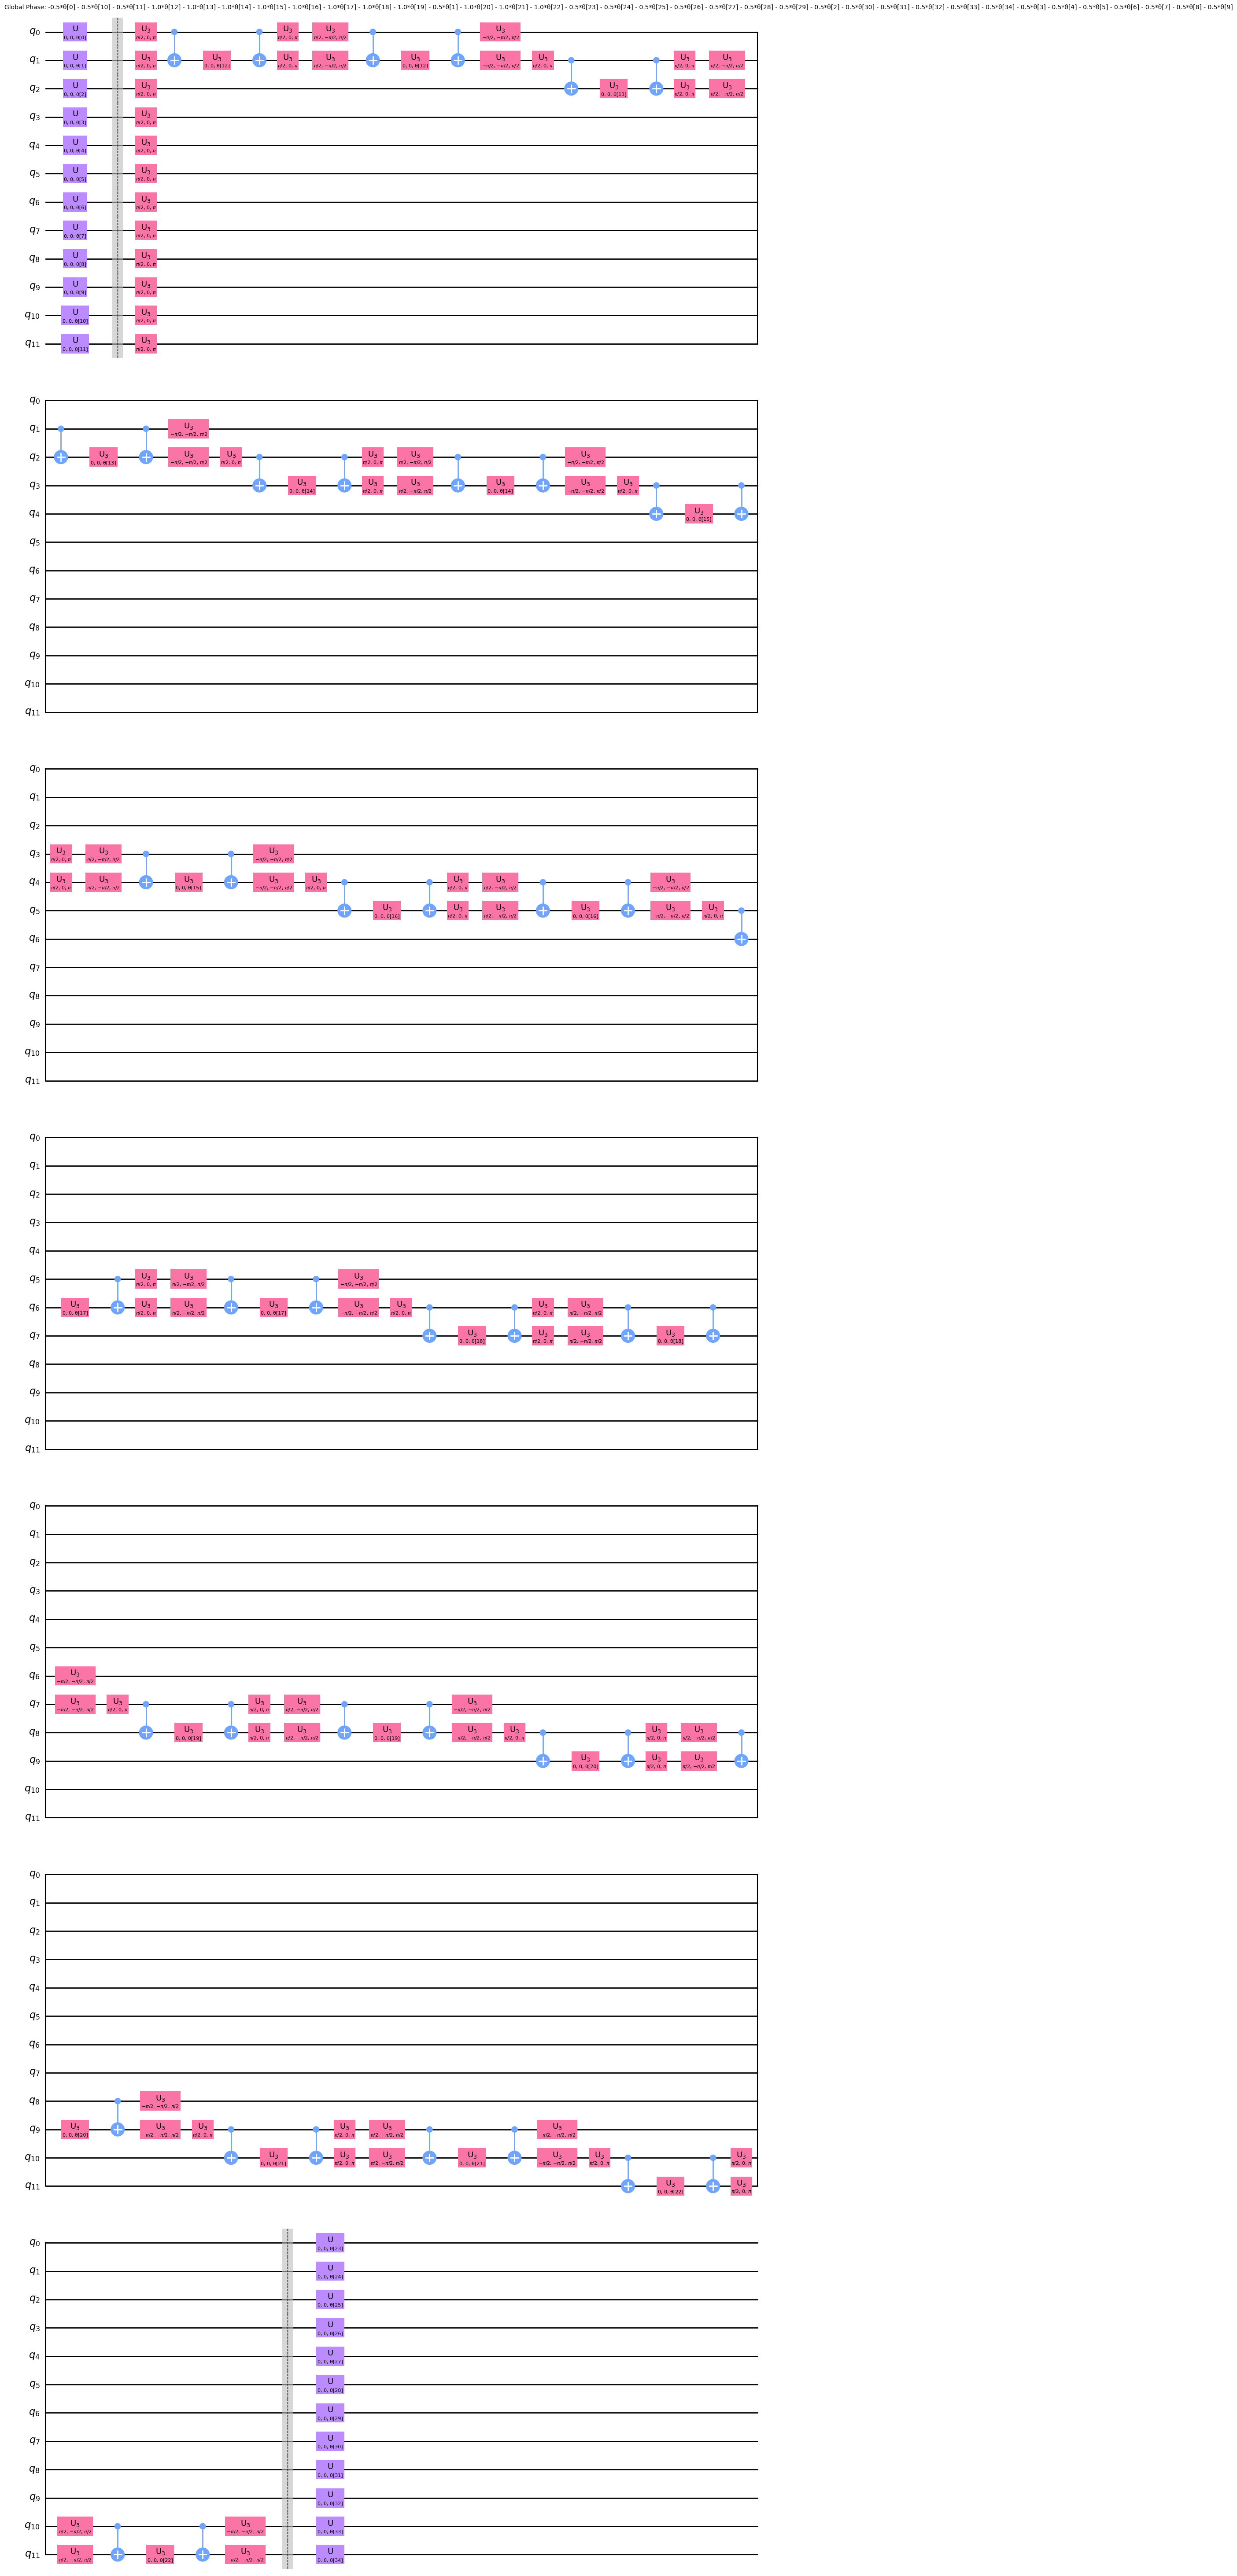

In [53]:
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, PauliTwoDesign, ExcitationPreserving

ansatz = ExcitationPreserving(H2_op.num_qubits, reps=1, insert_barriers=True, entanglement='linear')
ansatz = ansatz.decompose(reps=2)
 
print(ansatz.count_ops())
print(ansatz.depth())
ansatz.decompose(reps=2).draw('mpl')